In [11]:
%matplotlib inline

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'#Supress debug info. We don't have a GPU or TPU, and if TensorFlow doesn't 
                                        #find one, it gets upset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'
import tensorflow as tf
# import smt
# import pylatex
import warnings
import tqdm
import sklearn
import math

from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.metrics import r2_score
# from smt.applications.mfk import MFK, NestedLHS
# from smt.surrogate_models import KRG
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import qmc

# Benchmark Functions from Guo et al.
Guo, M., Manzoni, A, Amendt, M., Conti, P., Hesthaven, J.S., "Multi-fidelity regression using artificial neural networks: efficient approximation of parameter-dependent
output quantities," [arXiv:2102.13403](https://arxiv.org/abs/2102.13403), 2021.

## Benchmark 1: High Fidelity Function
$$ y_{hf} = (6x-2)^2sin(12x-4) $$

## Benchmark 1: Low Fidelity Function
$$ y_{lf} = 0.5y_{hf} + 10(x-0.5) + 5 $$

In [6]:
## Benchmark Functions 1
def hf_function_bench1(x):
    y_hf1 = ((6*x - 2)**2)*np.sin(12*x-4)
    return y_hf1

def lf_function_bench1(x):
    y_lf1 = .5*hf_function_bench1(x) + 10*(x-0.5) + 5
    return y_lf1

## Benchmark Function 1 Plot

## Benchmark 2: High Fidelity Function
$$ y_{hf} = 2y_{lf} - 20(x-1) \quad for \quad 0 \leq x < 0.5 $$
$$ y_{hf} = 4 + 2y_{lf} - 20(x-1) \quad for \quad 0.5 \leq x < 1.0 $$

## Benchmark 2: Low Fidelity Function
$$ y_{lf} = 0.5(6x - 2)^2 sin(12x-4) + 10(x-0.5) - 5 \quad for \quad 0 \leq x < 0.5 $$
$$ y_{lf} = 3 + 0.5(6x - 2)^2 sin(12x-4) + 10(x-0.5) - 5 \quad for \quad 0.5 \leq x < 1.0 $$

In [1]:
##Benchmark Functions 2
def lf_function_bench2(x):
    if 0 <= x < 0.5:
        y_lf2 = 0.5 * (6*x - 2)**2 * np.sin(12*x-4) + 10*(x - 0.5)
    else:
        y_lf2 =3 + 0.5 * (6*x - 2)**2 * np.sin(12*x-4) + 10*(x - 0.5)
    return y_lf2

def hf_function_bench2(x):
    if 0 <= x < 0.5:
        y_hf2 = 2 * lf_function_bench2(x) - 20*(x-1)
    else:
        y_hf2 = 4 + 2 * lf_function_bench2(x) - 20*(x-1)
    return y_hf2

## Benchmark 3: High Fidelity Function
$$ y_{hf} = \left(x-\sqrt2\right) y_{LF}^2 $$

## Benchmark 3: Low Fidelity Function
$$ y_{lf} = sin(8\pi x) $$

In [4]:
##Benchmark Function 3
def hf_function_bench3(x):
    y_hf3 = (x - np.sqrt(2)) *lf_function_bench3(x)**2
    return y_hf3

def lf_function_bench3(x):
    y_lf3 = np.sin(8*np.pi*x)
    return y_lf3

## Benchmark 4: High Fidelity Function
$$ y_{hf} = (x_1 - 1)^2 + \sum_{i=2}^{20} \left( 2x_i^2 - x_{i-1} \right)^2 $$

## Benchmark 4: Low Fidelity Function
$$ y_{lf} = 0.8 y_{hf} - \sum_{i=2}^{20} 0.4 x_{i-1} x_i - 50 $$

with $$ x = \{ x_1,x_2, ..., x_{20}\} \in \Omega = \left[ -3,3 \right]^{20} $$

It is well known that Gaussian Process Regression models suffer from the curse of dimensionality, and cannot be effectively used when the number of data points is very large (N >10000), especially when big data sets are needed to sufficiently cover the high-dimensional input space.  The current benchmark is chosen to show that, in contrast to GPR, NNs remain a valid candidate for MF regression in the presence of high dimensionality and large data sets.The following 20-dimensional functions define the MF setting in this example:

In Tyler's words: each time you "sample" the $\textbf{x}$ vector, each of the 20 points will be a random number from -3 to 3. So your high fidelity data will be a 20x5000 (or 5000x20 depending on how you build it), low fidelity data will be 20x30000 (or 30000x20). 

In [5]:
def hf_function_bench4(x):
    y_hf4 = (x[:,0] - 1)**2 + np.sum( np.power((2*np.power(x[:,1:],2) - x[:,0:-1]),2) )
    return y_hf4

def lf_function_bench4(x):
    y_lf4 = 0.8 * hf_function_bench4(x) - np.sum( 0.4*x[:,0:-1]*x[:,1:] - 50)
    return y_lf4

In [6]:
## Generate x samples for Benchmark 4: 

x_hf4 = np.random.uniform(low=-3,high=3,size=(5000,20))
x_lf4 = np.random.uniform(low=-3,high=3,size=(30000,20))

# Sampling

We'll use two different sampling techniques, uniform sampling and Latin Hypercube Sampling. With time, we may also use low discrepancy sequencing (LDS), which is included briefly in this notebook but not implemented. 

## Implementation of Latin Hypercube Sampling
In the code below, we will create two numpy arrays, xt_LF and xt_HF (x, training, low fidelity and high fidelity). Calling the SMT function NestedLHS requires 3 inputs, nlevel, xlimits, and random_state. nlevel is the number of "draws" you'd like to make using NestedLHS. We have 2 different functions, so nlevel = 2. If we had three functions (low, medium, and high fidelity), then nlevel=3. xlimits provides the function with our range, or limits on x. For our problem, we are evaluating the functions from x = 0->1 (defined in the numpy array xlimits). random_state is not used in our code., but random_state: Numpy RandomState object or seed number which controls random draws.

The number passed to xdoes in the code below tells the function how many points to draw from the range for the last variable, or in our case, the highest fidelity function. Each successive variable will have twice as many points. In our case, xt_HF will have the shape (7,1) and xt_LF will have the shape (14,1).

If we had a low, medium, and high fidelity function, and we called xdoes(7), then xt_HF.shape = (7,1), xt_MF.shape = (14,1), and xt_LF.shape = (28,1). 

In [7]:
with warnings.catch_warnings(record=True): #supresses error message 
    xlimits = np.array([[0.0, 1.0]])
    xdoes = NestedLHS(nlevel=2, xlimits=xlimits)
    xt_LF_lhs_bench1, xt_HF_lhs_bench1 = xdoes(7)
    xt_LF_lhs_bench2, xt_HF_lhs_bench2 = xdoes(8)
    xt_LF_lhs_bench3, xt_HF_lhs_bench3 = xdoes(15)

## Uniform Sampling
In the referenced paper, the authors used uniform sampling instead of a DOE sampling method like LHS. I will compare the results for both methods. 

In [3]:
## Uniform Sampling 
xt_LF_uni_bench1 = np.linspace(0, 1, num=32, endpoint=True).reshape(-1, 1)
xt_HF_uni_bench1 = np.linspace(0, 1, num=5, endpoint=True).reshape(-1, 1)


In [ ]:

x1 = np.linspace(0, 1, num=32, endpoint=True).reshape(-1, 1)
x2 = np.linspace(0.45, 0.55, num=10, endpoint=True).reshape(-1, 1)
x3 = np.concatenate((x1,x2),axis=0)
xt_LF_uni_bench2 = np.sort(x3, axis=0)
xt_HF_uni_bench2 = np.linspace(0, 1, num=8, endpoint=True).reshape(-1, 1)

xt_LF_uni_bench3 = np.linspace(0, 1, num=42, endpoint=True).reshape(-1, 1)
xt_HF_uni_bench3 = np.linspace(0, 1, num=15, endpoint=True).reshape(-1, 1)


In [4]:

## Continuous Sampling, used for plotting true function 
x = np.linspace(0, 1, num=101, endpoint=True).reshape(-1,1)

In [9]:
## Low Discrepency Sequence Sampling
## SciPy

# Generates 1d LDS points. Keep in mind, LDS requires your sampling to be a power of 2
def gen_LDS_points(num_points,num_dim):
    closestPower2 = math.ceil(np.sqrt(num_points))
    sampler = qmc.Sobol(d=num_dim, scramble=True)
    sample = sampler.random_base2(m=closestPower2)
    sample = np.append(sample, [1.0]) #.reshape(-1,1)
    return sample


In [12]:
## Getting an idea of how the LDS sampling works and what it looks like 

# x_lds1 = gen_LDS_points(5,1)
# x_lds2 = gen_LDS_points(32,1)

#Reference Functions, Benchmark 1
plt.plot(x,hf_function_bench1(x), label="True High Fidelity (HF) Function",linestyle="-.", color="k")
plt.plot(x,lf_function_bench1(x), label="True Low Fidelity (LF) Function",linestyle="-.", color="r")
#Training Points
# plt.scatter(x_lds1, hf_function_bench1(x_lds1), marker="*", color="g", label = "HF Low Discrepancy Sequence Sample Location")
# plt.scatter(x_lds2, lf_function_bench1(x_lds2), marker="o", color="g", label = "LF Low Discrepancy Sequence Sample Location")
plt.legend()
plt.xlabel('x (input)')
plt.ylabel('y (output)')
plt.show()

<Figure size 432x288 with 1 Axes>

# Training Data

## Generating Training Data

In this section, we're taking our sampling "x" points and generating "y" function results using the benchmark functions from the first section of this notebook. 

In [18]:
# yt == training outputs 
# hf , lf == high fidelity, low fidelity
# lhs == Latin Hypercube Sampling 
# uni == uniform sampling 
# bench1,2,3 == benchmark function from Guo paper, either 1, 2 or 3

#BENCHMARK FUNCTION 1, low and high fideltiy training data, LHS and Uniform sampling
yt_hf1_lhs = hf_function_bench1(xt_HF_lhs_bench1)
yt_lf1_lhs = lf_function_bench1(xt_LF_lhs_bench1)
yt_hf1_uni = hf_function_bench1(xt_HF_uni_bench1)
yt_lf1_uni = lf_function_bench1(xt_LF_uni_bench1)

#BENCHMARK FUNCTION 2, low and high fideltiy training data, LHS and Uniform sampling
# We have to map the function here because of the "if" statements in our function. 
# When we directly feed the x values into our function, it throws an error. Another way to 
# accomplish this is by using a "for" loop, and iterating from x1 to xN. However, vectorizing 
# the function and using the built-in "map" is faster and will scale better. 
yt_hf2_lhs = np.concatenate((list(map(hf_function_bench2, xt_HF_lhs_bench2))), axis=0).reshape(-1,1)
yt_lf2_lhs = np.concatenate((list(map(lf_function_bench2, xt_LF_lhs_bench2))), axis=0).reshape(-1,1)
yt_hf2_uni = np.concatenate((list(map(hf_function_bench2, xt_HF_uni_bench2))), axis=0).reshape(-1,1)
yt_lf2_uni = np.concatenate((list(map(lf_function_bench2, xt_LF_uni_bench2))), axis=0).reshape(-1,1)
y_truth_hf2_uni = np.concatenate((list(map(hf_function_bench2, x))), axis=0).reshape(-1,1)
y_truth_lf2_uni = np.concatenate((list(map(lf_function_bench2, x))), axis=0).reshape(-1,1)

#BENCHMARK FUNCTION 3, low and high fideltiy training data, LHS and Uniform sampling
yt_hf3_lhs = hf_function_bench3(xt_HF_lhs_bench3)
yt_lf3_lhs = lf_function_bench3(xt_LF_lhs_bench3)
yt_hf3_uni = hf_function_bench3(xt_HF_uni_bench3)
yt_lf3_uni = lf_function_bench3(xt_LF_uni_bench3)

In [5]:
yt_hf4 = hf_function_bench4(x_hf4).reshape(-1,1)
yt_lf4 = lf_function_bench4(x_lf4).reshape(-1,1)

## Plotting Training Data

Here, we're creating a visualisation of the benchmark functions and where the sampled points are coming from. The plots give you an idea of the distributions and the differences in the sampling techniques, as well as characterize the nature of the benchmark functions we're analyzing 

In [32]:
plt.rcParams["figure.figsize"] = (20,7)
fig, axs = plt.subplots(1, 3)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


#Reference Functions, Benchmark 1
axs[0].plot(x,hf_function_bench1(x), label="High Fidelity Function",linestyle="-.", color="k")
axs[0].plot(x,lf_function_bench1(x), label="Low Fidelity Function",linestyle="-.", color="r")

axs[1].plot(x,hf_function_bench1(x), label="High Fidelity Function",linestyle="-.", color="k")
axs[1].plot(x,lf_function_bench1(x), label="Low Fidelity Function",linestyle="-.", color="r")

axs[2].plot(x,hf_function_bench1(x), label="True High Fidelity (HF) Function",linestyle="-.", color="k")
axs[2].plot(x,lf_function_bench1(x), label="True Low Fidelity (LF) Function",linestyle="-.", color="r")

#Training Points
axs[2].scatter(x_lds1, hf_function_bench1(x_lds1), marker="*", color="b", label = "HF Low Discrepancy Sequence Sample Location")
axs[2].scatter(x_lds2, lf_function_bench1(x_lds2), marker="o", color="b", label = "LF Low Discrepancy Sequence Sample Location")
axs[2].legend()
axs[2].set_xlabel('x (input)')
axs[2].set_ylabel('y (output)')
axs[0].scatter(xt_HF_lhs_bench1, yt_hf1_lhs, marker="*", color="b", label = "HF LHS Points")
axs[0].scatter(xt_LF_lhs_bench1, yt_lf1_lhs, marker="o", color="b", label = "LF LHS Points")
axs[0].set_xlabel('x (input)')
axs[0].set_ylabel('y (output)')
axs[1].scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="*", color="b", label = "HF Uniform Points")
axs[1].scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="o", color="b", label = "LF Uniform Points")
axs[1].set_xlabel('x (input)')
axs[1].set_ylabel('y (output)')

axs[0].legend(loc=0)
axs[1].legend(loc=0)
axs[0].grid()
axs[1].grid()
axs[2].legend(loc=0)
axs[2].grid()

<Figure size 1440x504 with 3 Axes>

In [19]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


#Reference Functions, Benchmark 1
axs[0,0].plot(x,hf_function_bench1(x), label="High Fidelity Function",linestyle="-.", color="k")
axs[0,0].plot(x,lf_function_bench1(x), label="Low Fidelity Function",linestyle="-.", color="r")

# textstr = '\n'.join(
#     r'$ y_{hf} = (6x-2)^2sin(12x-4) $' 
#     r'$ y_{lf} = 0.5y_{hf} + 10(x-0.5) + 5 $'  
#     )

# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# # place a text box in upper left in axes coords
# axs[0,0].text(0.05, 0.95, textstr, transform=axs[0,0].transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

#Training Points
axs[0,0].scatter(xt_HF_lhs_bench1, yt_hf1_lhs, marker="*", color="g", label = "HF LHS Points")
axs[0,0].scatter(xt_LF_lhs_bench1, yt_lf1_lhs, marker="o", color="g", label = "LF LHS Points")
axs[0,0].scatter(xt_HF_uni_bench1, yt_hf1_uni, marker="X", color="b", label = "HF Uniform Points")
axs[0,0].scatter(xt_LF_uni_bench1, yt_lf1_uni, marker="d", color="b", label = "LF Uniform Points")

axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Reference Functions, Benchmark 2
axs[0,1].plot(x,y_truth_hf2_uni, label="High Fidelity Function",linestyle="-.", color="k")
axs[0,1].plot(x,y_truth_lf2_uni, label="Low Fidelity Function",linestyle="-.", color="r")
#Training Points
axs[0,1].scatter(xt_HF_lhs_bench2, yt_hf2_lhs, marker="*", color="g", label = "HF LHS Points")
axs[0,1].scatter(xt_LF_lhs_bench2, yt_lf2_lhs, marker="o", color="g", label = "LF LHS Points")
axs[0,1].scatter(xt_HF_uni_bench2, yt_hf2_uni, marker="X", color="b", label = "HF Uniform Points")
axs[0,1].scatter(xt_LF_uni_bench2, yt_lf2_uni, marker="d", color="b", label = "LF Uniform Points")
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Reference Functions, Benchmark 3
axs[1,0].plot(x,hf_function_bench3(x), label="High Fideltiy Function",linestyle="-.", color="k")
axs[1,0].plot(x,lf_function_bench3(x), label="Low Fidelity Function",linestyle="-.", color="r")
#Training Points
axs[1,0].scatter(xt_HF_lhs_bench3, yt_hf3_lhs, marker="*", color="g", label = "HF LHS Points")
axs[1,0].scatter(xt_LF_lhs_bench3, yt_lf3_lhs, marker="o", color="g", label = "LF LHS Points")
axs[1,0].scatter(xt_HF_uni_bench3, yt_hf3_uni, marker="X", color="b", label = "HF Uniform Points")
axs[1,0].scatter(xt_LF_uni_bench3, yt_lf3_uni, marker="d", color="b", label = "LF Uniform Points")
axs[1,0].set_title("Benchmark Function 3")
axs[1,0].legend(loc=0)
axs[1,0].grid()

<Figure size 720x720 with 4 Axes>

# Kriging, or Gaussian Process Models

## Surrogate Modeling Toolbox (SMT)

All code used here is from the Surrogate Modeling Toolbox Module. The MFK from SMT doesn't allow for sufficient control of hyperparameters, so the author has switched to using the sklearn GP module

In [81]:
# # theta0 is the initial hyperparameters. Default value is [0.01], we are setting it to [1.0]. It wants the data type
# # to either be a list or an ndarray. Other Kriging problems use the default as the initial hyperparameter value. We'll
# # see how it ends up after the model is trained. This is the procedure used in the smt example 

# #All of the theta0 values are [1.0]. 

# # SurrogateModel_Bench1_lhs = MFK(theta0=xt_HF_lhs_bench1.shape[1]*[1.0])
# # SurrogateModel_Bench1_uni = MFK(theta0=xt_HF_uni_bench1.shape[1]*[1.0])
# # SurrogateModel_Bench2_lhs = MFK(theta0=xt_HF_lhs_bench2.shape[1]*[1.0])
# # SurrogateModel_Bench2_uni = MFK(theta0=xt_HF_uni_bench2.shape[1]*[1.0])
# # SurrogateModel_Bench3_lhs = MFK(theta0=xt_HF_lhs_bench3.shape[1]*[1.0])
# # SurrogateModel_Bench3_uni = MFK(theta0=xt_HF_uni_bench3.shape[1]*[1.0])

# SurrogateModel_Bench1_lhs = None
# SurrogateModel_Bench1_uni = None
# SurrogateModel_Bench2_lhs = None
# SurrogateModel_Bench2_uni = None
# SurrogateModel_Bench3_lhs = None
# SurrogateModel_Bench3_uni = None

# SurrogateModel_Bench1_lhs = MFK()
# SurrogateModel_Bench1_uni = MFK()
# SurrogateModel_Bench2_lhs = MFK()
# SurrogateModel_Bench2_uni = MFK()
# SurrogateModel_Bench3_lhs = MFK()
# SurrogateModel_Bench3_uni = MFK()

# # Set Training Values for all of our Kriging surrogate models 
# name = 0
# SurrogateModel_Bench1_lhs.set_training_values(xt_LF_lhs_bench1,yt_lf1_lhs, name) #='Low Fidelity, LHS, bench 1')
# SurrogateModel_Bench1_lhs.set_training_values(xt_HF_lhs_bench1,yt_hf1_lhs) #, name='High Fidelity, LHS, bench 1')
# SurrogateModel_Bench1_uni.set_training_values(xt_LF_uni_bench1,yt_lf1_uni, name) #, name='Low Fidelity, Uniform, bench 1')
# SurrogateModel_Bench1_uni.set_training_values(xt_HF_uni_bench1,yt_hf1_uni) #, name='High Fidelity, Uniform, bench 1')

# SurrogateModel_Bench2_lhs.set_training_values(xt_LF_lhs_bench2,yt_lf2_lhs, name) #='Low Fidelity, LHS, bench 2')
# SurrogateModel_Bench2_lhs.set_training_values(xt_HF_lhs_bench2,yt_hf2_lhs) #, name='High Fidelity, LHS, bench 2')
# SurrogateModel_Bench2_uni.set_training_values(xt_LF_uni_bench2,yt_lf2_uni, name) #='Low Fidelity, Uniform, bench 2')
# SurrogateModel_Bench2_uni.set_training_values(xt_HF_uni_bench2,yt_hf2_uni) #, name='High Fidelity, Uniform, bench 2')

# SurrogateModel_Bench3_lhs.set_training_values(xt_LF_lhs_bench3,lhs_yTrainLoFi, name) #='Low Fidelity, LHS, bench 3')
# SurrogateModel_Bench3_lhs.set_training_values(xt_HF_lhs_bench3,lhs_yTrainHiFi) #, name='High Fidelity, LHS, bench 3')
# SurrogateModel_Bench3_uni.set_training_values(xt_LF_uni_bench3,uni_yTrainLoFi, name) #='Low Fidelity, Uniform, bench 3')
# SurrogateModel_Bench3_uni.set_training_values(xt_HF_uni_bench3,uni_yTrainHiFi) #, name='High Fidelity, Uniform, bench 3')

# # Training the model
# # SurrogateModel.train()

# SurrogateModel_Bench1_lhs.train()
# SurrogateModel_Bench1_uni.train()

# SurrogateModel_Bench2_lhs.train()
# SurrogateModel_Bench2_uni.train()

# SurrogateModel_Bench3_lhs.train()
# SurrogateModel_Bench3_uni.train()

# x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# # y_predict_bench1_lhs = SurrogateModel.predict_values(x)
# # MeanSquaredError = SurrogateModel.predict_variances(x)
# # Derivatives = SurrogateModel.predict_derivatives(x, kx = 0)

# y_predict_bench1_lhs = SurrogateModel_Bench1_lhs.predict_values(x)
# y_predict_bench1_uni = SurrogateModel_Bench1_uni.predict_values(x)
# MSE_bench1_lhs = SurrogateModel_Bench1_lhs.predict_variances(x)
# MSE_bench1_uni = SurrogateModel_Bench1_uni.predict_variances(x)
# deriv_bench1_lhs = SurrogateModel_Bench1_lhs.predict_derivatives(x, kx = 0)
# deriv_bench1_uni = SurrogateModel_Bench1_uni.predict_derivatives(x, kx = 0)

# y_predict_bench2_lhs = SurrogateModel_Bench2_lhs.predict_values(x)
# y_predict_bench2_uni = SurrogateModel_Bench2_uni.predict_values(x)
# MSE_bench2_lhs = SurrogateModel_Bench2_lhs.predict_variances(x)
# MSE_bench2_uni = SurrogateModel_Bench2_uni.predict_variances(x)
# deriv_bench2_lhs = SurrogateModel_Bench2_lhs.predict_derivatives(x, kx = 0)
# deriv_bench2_uni = SurrogateModel_Bench2_uni.predict_derivatives(x, kx = 0)

# y_predict_bench3_lhs = SurrogateModel_Bench3_lhs.predict_values(x)
# y_predict_bench3_uni = SurrogateModel_Bench3_uni.predict_values(x)
# MSE_bench3_lhs = SurrogateModel_Bench3_lhs.predict_variances(x)
# MSE_bench3_uni = SurrogateModel_Bench3_uni.predict_variances(x)
# # deriv_bench3_lhs = SurrogateModel_Bench3_lhs.predict_derivatives(x, kx = 0)
# # deriv_bench3_uni = SurrogateModel_Bench3_uni.predict_derivatives(x, kx = 0)

# # lhs_yTrainLoFi = lhsScalerLoFi.fit_transform(yt_lf3_lhs)
# # lhs_yTrainHiFi = lhsScalerHiFi.fit_transform(yt_hf3_lhs)
# # uni_yTrainLoFi = uniScalerLoFi.fit_transform(yt_lf3_uni)
# # uni_yTrainHiFi = uniScalerHiFi.fit_transform(yt_hf3_uni)

# y_predict_bench3_lhs = lhsScalerHiFi.inverse_transform(y_predict_bench3_lhs)
# y_predict_bench3_uni = uniScalerHiFi.inverse_transform(y_predict_bench3_uni)

# plt.rcParams["figure.figsize"] = (10,10)
# fig, axs = plt.subplots(2, 2)
# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# #Reference Functions, Benchmark 1
# axs[0,0].plot(x,hf_function_bench1(x), label="True HF Function",linestyle="-", color="k")
# axs[0,0].plot(x,lf_function_bench1(x), label="True LF Function",linestyle="-", color="k")
# #Predicted Values 
# axs[0,0].plot(x,y_predict_bench1_lhs, label="MFK LHS Predicted",linestyle="-.", color="b")
# axs[0,0].plot(x,y_predict_bench1_uni, label="MFK Uni Predicted",linestyle=":", color="r")
# axs[0,0].set_title("Benchmark Function 1")
# axs[0,0].legend(loc=0)
# axs[0,0].grid()

# #Reference Functions, Benchmark 2
# axs[0,1].plot(x,y_truth_hf2_uni, label="True HF Function",linestyle="-", color="k")
# axs[0,1].plot(x,y_truth_lf2_uni, label="True LF Function",linestyle="-", color="k")
# #Training Points
# axs[0,1].plot(x,y_predict_bench2_lhs, label="MFK LHS Predicted",linestyle="-.", color="b")
# axs[0,1].plot(x,y_predict_bench2_uni, label="MFK Uni Predicted",linestyle=":", color="r")
# axs[0,1].set_title("Benchmark Function 2")
# axs[0,1].legend(loc=0)
# axs[0,1].grid()

# #Reference Functions, Benchmark 3
# axs[1,0].plot(x,hf_function_bench3(x), label="True HF Function",linestyle="-", color="k")
# axs[1,0].plot(x,lf_function_bench3(x), label="True LF Function",linestyle="-", color="k")

# axs[1,0].plot(x,y_predict_bench3_lhs, label="MFK LHS Predicted",linestyle="-.", color="b")
# axs[1,0].plot(x,y_predict_bench3_uni, label="MFK Uni Predicted",linestyle=":", color="r")
# axs[1,0].set_title("Benchmark Function 3")
# axs[1,0].legend(loc=0)
# axs[1,0].grid()

# #Training Points
# axs[1,0].scatter(xt_HF_lhs_bench3, yt_hf3_lhs, marker="*", color="g", label = "HF LHS Points")
# # axs[1,0].scatter(xt_LF_lhs_bench3, yt_lf3_lhs, marker="o", color="g", label = "LF LHS Points")
# axs[1,0].scatter(xt_HF_uni_bench3, yt_hf3_uni, marker="X", color="b", label = "HF Uniform Points")
# # axs[1,0].scatter(xt_LF_uni_bench3, yt_lf3_uni, marker="d", color="b", label = "LF Uniform Points")

## sklearn Gaussian Process

*Building our multi-fidelity kriging the ol' fashioned way* 

This way provides the user control over the hyperparameters (specifically the kernels, n restarts optimizer)

kernel: class-kernel instance, default=None
The kernel specifying the covariance function of the GP. If None is passed, the kernel ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed") is used as default. Note that the kernel hyperparameters are optimized during fitting unless the bounds are marked as “fixed”.

n_restarts_optimizer: class-int, default=0
The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.

### Data Scaling

In order to model effectively, we'll want to scale our training data appropriately. In this case, we're using sklearn's ```preprocessing.StandardScaler()```. The module standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as: ```z = (x - u) / s```, where ```u``` is the mean of the training samples or zero if ```with_mean=False```, and ```s``` is the standard deviation of the training samples or one if ```with_std=False```.

This is included in the comments of the below code block, but keep in my that each data set needs its own distinct scaler object. If you don't create a scaler object for each data set, you won't be able to inverse transform the data properly. 

In [ ]:
# The author of this notebook accidentally created two blocks of code that do the same thing. This code is redundant
# with the block of code below, but I kept it... just in case. 

# # Scaling benchmark 1 data 
# lhsScalerLoFi1 = None
# lhsScalerHiFi1 = None
# uniScalerLoFi1 = None
# uniScalerHiFi1 = None

# lhsScalerLoFi1 = preprocessing.StandardScaler()
# lhsScalerHiFi1 = preprocessing.StandardScaler()
# uniScalerLoFi1 = preprocessing.StandardScaler()
# uniScalerHiFi1 = preprocessing.StandardScaler()

# lhs_yTrainLoFi1 = lhsScalerLoFi1.fit_transform(yt_lf1_lhs)
# lhs_yTrainHiFi1 = lhsScalerHiFi1.fit_transform(yt_hf1_lhs)
# uni_yTrainLoFi1 = uniScalerLoFi1.fit_transform(yt_lf1_uni)
# uni_yTrainHiFi1 = uniScalerHiFi1.fit_transform(yt_hf1_uni)
# #########
# # Scaling benchmark 2 data 
# lhsScalerLoFi2 = None
# lhsScalerHiFi2 = None
# uniScalerLoFi2 = None
# uniScalerHiFi2 = None

# lhsScalerLoFi2 = preprocessing.StandardScaler()
# lhsScalerHiFi2 = preprocessing.StandardScaler()
# uniScalerLoFi2 = preprocessing.StandardScaler()
# uniScalerHiFi2 = preprocessing.StandardScaler()

# lhs_yTrainLoFi2 = lhsScalerLoFi2.fit_transform(yt_lf2_lhs)
# lhs_yTrainHiFi2 = lhsScalerHiFi2.fit_transform(yt_hf2_lhs)
# uni_yTrainLoFi2 = uniScalerLoFi2.fit_transform(yt_lf2_uni)
# uni_yTrainHiFi2 = uniScalerHiFi2.fit_transform(yt_hf2_uni)
# #########
# # Scaling benchmark 3 data 
# lhsScalerLoFi3 = None
# lhsScalerHiFi3 = None
# uniScalerLoFi3 = None
# uniScalerHiFi3 = None

# lhsScalerLoFi3 = preprocessing.StandardScaler()
# lhsScalerHiFi3 = preprocessing.StandardScaler()
# uniScalerLoFi3 = preprocessing.StandardScaler()
# uniScalerHiFi3 = preprocessing.StandardScaler()

# lhs_yTrainLoFi3 = lhsScalerLoFi3.fit_transform(yt_lf3_lhs)
# lhs_yTrainHiFi3 = lhsScalerHiFi3.fit_transform(yt_hf3_lhs)
# uni_yTrainLoFi3 = uniScalerLoFi3.fit_transform(yt_lf3_uni)
# uni_yTrainHiFi3 = uniScalerHiFi3.fit_transform(yt_hf3_uni)

In [38]:
# Creating a variable that points to the preprocessing.StandardScaler() module. Each dataset needs its own
# scaler object for the inverse transformation. Otherwise, we'll be "inverse transforming" data set "x" using
# the scaling operations for data set "y."

lfScalerLHS1 = None
hfScalerLHS1 = None
lfScalerUni1 = None
hfScalerUni1 = None
lfScalerLHS1 = preprocessing.StandardScaler()
hfScalerLHS1 = preprocessing.StandardScaler()
lfScalerUni1 = preprocessing.StandardScaler()
hfScalerUni1 = preprocessing.StandardScaler()

lfScalerLDS1 = None
hfScalerLDS1 = None
lfScalerLDS1 = preprocessing.StandardScaler()
hfScalerLDS1 = preprocessing.StandardScaler()

lfScalerLHS2= None
hfScalerLHS2= None
lfScalerUni2= None
hfScalerUni2= None
lfScalerLHS2= preprocessing.StandardScaler()
hfScalerLHS2= preprocessing.StandardScaler()
lfScalerUni2= preprocessing.StandardScaler()
hfScalerUni2= preprocessing.StandardScaler()

lfScalerLHS3= None
hfScalerLHS3= None
lfScalerUni3= None
hfScalerUni3= None
lfScalerLHS3= preprocessing.StandardScaler()
hfScalerLHS3= preprocessing.StandardScaler()
lfScalerUni3= preprocessing.StandardScaler()
hfScalerUni3= preprocessing.StandardScaler()

In [6]:
lfScaler4 = None
hfScaler4 = None
lfScaler4 = preprocessing.StandardScaler()
hfScaler4 = preprocessing.StandardScaler()

In [42]:
# Using the scaler objects that we've created

yt_lf1_lhs_scaled = lfScalerLHS1.fit_transform(yt_lf1_lhs)
yt_hf1_lhs_scaled = hfScalerLHS1.fit_transform(yt_hf1_lhs)
yt_lf1_uni_scaled = lfScalerUni1.fit_transform(yt_lf1_uni)
yt_hf1_uni_scaled = hfScalerUni1.fit_transform(yt_hf1_uni)

yt_hf1_lds_scaled = hfScalerLDS1.fit_transform(hf_function_bench1(x_lds1).reshape(-1, 1))
yt_lf1_lds_scaled = lfScalerLDS1.fit_transform(lf_function_bench1(x_lds2).reshape(-1, 1))

yt_lf2_lhs_scaled = lfScalerLHS2.fit_transform(yt_lf2_lhs)
yt_hf2_lhs_scaled = hfScalerLHS2.fit_transform(yt_hf2_lhs)
yt_lf2_uni_scaled = lfScalerUni2.fit_transform(yt_lf2_uni)
yt_hf2_uni_scaled = hfScalerUni2.fit_transform(yt_hf2_uni)

yt_lf3_lhs_scaled = lfScalerLHS3.fit_transform(yt_lf3_lhs)
yt_hf3_lhs_scaled = hfScalerLHS3.fit_transform(yt_hf3_lhs)
yt_lf3_uni_scaled = lfScalerUni3.fit_transform(yt_lf3_uni)
yt_hf3_uni_scaled = hfScalerUni3.fit_transform(yt_hf3_uni)

In [7]:
# yt_hf4 = hf_function_bench4(x_hf4)
# yt_lf4 = lf_function_bench4(x_lf4)

yt_lf4_scaled = lfScaler4.fit_transform(yt_lf4)
yt_hf4_scaled = hfScaler4.fit_transform(yt_hf4)

#### Visual representation of the scaling of our training data. 
Top curve is actual data, bottom curve is scaled 

In [82]:
# # #Training Data
# plt.scatter(xt_LF_uni_bench1,yt_lf1_uni,color="b",label="Training Data")
# # #Training Data
# plt.scatter(xt_LF_uni_bench1,yt_lf1_uni_scaled,color="b",label="Scaled Training Data")
# #Reference Function
# plt.plot(x,lf_function_bench1(x), color="k",label="True HF Function")
# #Predicted MF NN
# plt.plot(x,lf_predict_output, linestyle="-.",color="m", label = "Predicted MF NN")


### Kernels

#### What kernels do/how to select kernels: 
https://www.cs.toronto.edu/~duvenaud/cookbook/

In [35]:
# Kernel options include: Compound, Constant, Dot Product, Exponentiation, ExpSineSquared, 
# Product, Rational Quadratic, RBF, Sum, White

# Benchmark Function 1
kernel1 = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(1.0, (1e-8, 1e2)) # Works great for Benchmark Function 1

#Benchmark Function 2
kernel2 = 66.3*RBF(0.1, (1e-8, 1e2)) #seems to work well for discontinuities, so we'll try for Benchmark Function 2

#Benchmark Function 3
kernel3 = kernel2

# Below are the different kernels (and combinations of kernels) that Dr. Reasor used in his code

#kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
#kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
#kernel = RationalQuadratic()
#kernel = Matern(length_scale=0.1, nu=2.5)  #
#kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
#kernel = ConstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))

### Fitting the Data and Inverse Transforming

In [48]:
krig_lf_lds1 = None
krig_lf_lds1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_lf_lds1.fit(x_lds2.reshape(-1,1), yt_lf1_lds_scaled)
krig_lf_lds1_predict_output = krig_lf_lds1.predict(x)
krig_lf_lds1_predict_output = lfScalerLDS1.inverse_transform(krig_lf_lds1_predict_output)

krig_hf_lds1 = None
krig_hf_lds1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_hf_lds1.fit(x_lds1.reshape(-1,1), yt_hf1_lds_scaled)
krig_hf_lds1_predict_output = krig_hf_lds1.predict(x)
krig_hf_lds1_predict_output = hfScalerLDS1.inverse_transform(krig_hf_lds1_predict_output)

krig_mf_lds1 = None
krig_mf_lds1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
in_mf_lds1 = x_lds1.reshape(-1,1)
ylf_lds1_in = krig_lf_lds1.predict(in_mf_lds1)
in_mf_lds1 = np.concatenate((in_mf_lds1,ylf_lds1_in),axis=1)
krig_mf_lds1.fit(in_mf_lds1, yt_hf1_lds_scaled)
ylf_lds1_in2 = krig_lf_lds1.predict(x)
in_mf2_lds1 = np.concatenate((x,ylf_lds1_in2),axis=1)
krig_mf_lds1_predict = krig_mf_lds1.predict(in_mf2_lds1)
krig_mf_lds1_predict = hfScalerLDS1.inverse_transform(krig_mf_lds1_predict)

/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find 

In [46]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# Low Fidelity Models 
krig_lf_uni1 = None
krig_lf_lhs1 = None
krig_lf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_lf_lhs1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_lf_uni1.fit(xt_LF_uni_bench1, yt_lf1_uni_scaled)
krig_lf_lhs1.fit(xt_LF_lhs_bench1, yt_lf1_lhs_scaled)
krig_lf_uni1_predict_output = krig_lf_uni1.predict(x)
krig_lf_lhs1_predict_output = krig_lf_lhs1.predict(x)
krig_lf_uni1_predict_output = lfScalerUni1.inverse_transform(krig_lf_uni1_predict_output)
krig_lf_lhs1_predict_output = lfScalerLHS1.inverse_transform(krig_lf_lhs1_predict_output)


krig_lf_uni2 = None
krig_lf_lhs2 = None
krig_lf_uni2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_lf_lhs2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_lf_uni2.fit(xt_LF_uni_bench2, yt_lf2_uni_scaled)
krig_lf_lhs2.fit(xt_LF_lhs_bench2, yt_lf2_lhs_scaled)
krig_lf_uni2_predict_output = krig_lf_uni2.predict(x)
krig_lf_lhs2_predict_output = krig_lf_lhs2.predict(x)
krig_lf_uni2_predict_output = lfScalerUni2.inverse_transform(krig_lf_uni2_predict_output)
krig_lf_lhs2_predict_output = lfScalerLHS2.inverse_transform(krig_lf_lhs2_predict_output)

krig_lf_uni3 = None
krig_lf_lhs3 = None
krig_lf_uni3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)
krig_lf_lhs3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)
krig_lf_uni3.fit(xt_LF_uni_bench3, yt_lf3_uni_scaled)
krig_lf_lhs3.fit(xt_LF_lhs_bench3, yt_lf3_lhs_scaled)
krig_lf_uni3_predict_output = krig_lf_uni3.predict(x)
krig_lf_lhs3_predict_output = krig_lf_lhs3.predict(x)
krig_lf_uni3_predict_output = lfScalerUni3.inverse_transform(krig_lf_uni3_predict_output)
krig_lf_lhs3_predict_output = lfScalerLHS3.inverse_transform(krig_lf_lhs3_predict_output)

# High Fidelity Models
krig_hf_uni1 = None
krig_hf_lhs1 = None
krig_hf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_hf_lhs1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_hf_uni1.fit(xt_HF_uni_bench1, yt_hf1_uni_scaled)
krig_hf_lhs1.fit(xt_HF_lhs_bench1, yt_hf1_lhs_scaled)
krig_hf_uni1_predict_output = krig_hf_uni1.predict(x)
krig_hf_lhs1_predict_output = krig_hf_lhs1.predict(x)
krig_hf_uni1_predict_output = hfScalerUni1.inverse_transform(krig_hf_uni1_predict_output)
krig_hf_lhs1_predict_output = hfScalerLHS1.inverse_transform(krig_hf_lhs1_predict_output)

krig_hf_uni2 = None
krig_hf_lhs2 = None
krig_hf_uni2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_hf_lhs2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_hf_uni2.fit(xt_HF_uni_bench2, yt_hf2_uni_scaled)
krig_hf_lhs2.fit(xt_HF_lhs_bench2, yt_hf2_lhs_scaled)
krig_hf_uni2_predict_output = krig_hf_uni2.predict(x)
krig_hf_lhs2_predict_output = krig_hf_lhs2.predict(x)
krig_hf_uni2_predict_output = hfScalerUni2.inverse_transform(krig_hf_uni2_predict_output)
krig_hf_lhs2_predict_output = hfScalerLHS2.inverse_transform(krig_hf_lhs2_predict_output)

krig_hf_uni3 = None
krig_hf_lhs3 = None
krig_hf_uni3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)
krig_hf_lhs3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)
krig_hf_uni3.fit(xt_HF_uni_bench3, yt_hf3_uni_scaled)
krig_hf_lhs3.fit(xt_HF_lhs_bench3, yt_hf3_lhs_scaled)
krig_hf_uni3_predict_output = krig_hf_uni3.predict(x)
krig_hf_lhs3_predict_output = krig_hf_lhs3.predict(x)
krig_hf_uni3_predict_output = hfScalerUni3.inverse_transform(krig_hf_uni3_predict_output)
krig_hf_lhs3_predict_output = hfScalerLHS3.inverse_transform(krig_hf_lhs3_predict_output)
 
# Multi Fidelity Models 
krig_mf_uni1 = None
krig_mf_lhs1 = None
krig_mf_uni1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_mf_lhs1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer=20)
krig_mf_uni2 = None
krig_mf_lhs2 = None
krig_mf_uni2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_mf_lhs2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=20)
krig_mf_uni3 = None
krig_mf_lhs3 = None
krig_mf_uni3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)
krig_mf_lhs3 = gaussian_process.GaussianProcessRegressor(kernel=kernel3,n_restarts_optimizer=20)

in_mf_uni1 = xt_HF_uni_bench1
in_mf_lhs1 = xt_HF_lhs_bench1
in_mf_uni2 = xt_HF_uni_bench2
in_mf_lhs2 = xt_HF_lhs_bench2
in_mf_uni3 = xt_HF_uni_bench3
in_mf_lhs3 = xt_HF_lhs_bench3

ylf_uni1_in = krig_lf_uni1.predict(in_mf_uni1)
ylf_lhs1_in = krig_lf_uni1.predict(in_mf_lhs1)
ylf_uni2_in = krig_lf_uni2.predict(in_mf_uni2)
ylf_lhs2_in = krig_lf_uni2.predict(in_mf_lhs2)
ylf_uni3_in = krig_lf_uni3.predict(in_mf_uni3)
ylf_lhs3_in = krig_lf_uni3.predict(in_mf_lhs3)

in_mf_uni1 = np.concatenate((in_mf_uni1,ylf_uni1_in),axis=1)
in_mf_lhs1 = np.concatenate((in_mf_lhs1,ylf_lhs1_in),axis=1)
in_mf_uni2 = np.concatenate((in_mf_uni2,ylf_uni2_in),axis=1)
in_mf_lhs2 = np.concatenate((in_mf_lhs2,ylf_lhs2_in),axis=1)
in_mf_uni3 = np.concatenate((in_mf_uni3,ylf_uni3_in),axis=1)
in_mf_lhs3 = np.concatenate((in_mf_lhs3,ylf_lhs3_in),axis=1)

krig_mf_uni1.fit(in_mf_uni1, yt_hf1_uni_scaled)
krig_mf_lhs1.fit(in_mf_lhs1, yt_hf1_lhs_scaled)
krig_mf_uni2.fit(in_mf_uni2, yt_hf2_uni_scaled)
krig_mf_lhs2.fit(in_mf_lhs2, yt_hf2_lhs_scaled)
krig_mf_uni3.fit(in_mf_uni3, yt_hf3_uni_scaled)
krig_mf_lhs3.fit(in_mf_lhs3, yt_hf3_lhs_scaled)

ylf_uni1_in2 = krig_lf_uni1.predict(x)
ylf_lhs1_in2 = krig_lf_uni1.predict(x)
ylf_uni2_in2 = krig_lf_uni2.predict(x)
ylf_lhs2_in2 = krig_lf_uni2.predict(x)
ylf_uni3_in2 = krig_lf_uni3.predict(x)
ylf_lhs3_in2 = krig_lf_uni3.predict(x)

in_mf2_uni1 = np.concatenate((x,ylf_uni1_in2),axis=1)
in_mf2_lhs1 = np.concatenate((x,ylf_lhs1_in2),axis=1)
in_mf2_uni2 = np.concatenate((x,ylf_uni2_in2),axis=1)
in_mf2_lhs2 = np.concatenate((x,ylf_lhs2_in2),axis=1)
in_mf2_uni3 = np.concatenate((x,ylf_uni3_in2),axis=1)
in_mf2_lhs3 = np.concatenate((x,ylf_lhs3_in2),axis=1)

krig_mf_uni1_predict = krig_mf_uni1.predict(in_mf2_uni1)
krig_mf_lhs1_predict = krig_mf_lhs1.predict(in_mf2_lhs1)
krig_mf_uni2_predict = krig_mf_uni2.predict(in_mf2_uni2)
krig_mf_lhs2_predict = krig_mf_lhs2.predict(in_mf2_lhs2)
krig_mf_uni3_predict = krig_mf_uni3.predict(in_mf2_uni3)
krig_mf_lhs3_predict = krig_mf_lhs3.predict(in_mf2_lhs3)

krig_mf_uni1_predict = hfScalerUni1.inverse_transform(krig_mf_uni1_predict)
krig_mf_lhs1_predict = hfScalerLHS1.inverse_transform(krig_mf_lhs1_predict)
krig_mf_uni2_predict = hfScalerUni2.inverse_transform(krig_mf_uni2_predict)
krig_mf_lhs2_predict = hfScalerLHS2.inverse_transform(krig_mf_lhs2_predict)
krig_mf_uni3_predict = hfScalerUni3.inverse_transform(krig_mf_uni3_predict)
krig_mf_lhs3_predict = hfScalerLHS3.inverse_transform(krig_mf_lhs3_predict)

/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/tkorenyi/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

### Plotting Our Models

In [58]:
plt.rcParams["figure.figsize"] = (7,7)
fig, axs = plt.subplots(1, 1)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Reference Functions, Benchmark 1
plt.plot(x,hf_function_bench1(x), label="High Fidelity Function",linestyle="-.", color="k")
# plt.plot(x,lf_function_bench1(x), label="Low Fidelity Function",linestyle="--", color="k")

#Predicted Values 
plt.plot(x,krig_mf_lhs1_predict, label="MFK LHS Predicted",linestyle="-.", color="b")
plt.plot(x,krig_mf_uni1_predict, label="MFK Uni Predicted",linestyle=":", color="r")
plt.plot(x,krig_mf_lds1_predict, label="MFK LDS Predicted",linestyle="--", color="g")

plt.xlabel('x (input)')
plt.ylabel('y (output)')
plt.legend(loc=0, prop={"size":20})
plt.grid()

<Figure size 504x504 with 1 Axes>

In [37]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Reference Functions, Benchmark 1
axs[0,0].plot(x,hf_function_bench1(x), label="True HF Function",linestyle="-", color="k")
axs[0,0].plot(x,lf_function_bench1(x), label="True LF Function",linestyle="--", color="k")
#Predicted Values 
axs[0,0].plot(x,krig_mf_lhs1_predict, label="MFK LHS Predicted",linestyle="-.", color="b")
axs[0,0].plot(x,krig_mf_uni1_predict, label="MFK Uni Predicted",linestyle=":", color="r")
axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Reference Functions, Benchmark 2
axs[0,1].plot(x,y_truth_hf2_uni, label="True HF Function",linestyle="-", color="k")
axs[0,1].plot(x,y_truth_lf2_uni, label="True LF Function",linestyle="--", color="k")
#Training Points
axs[0,1].plot(x,krig_mf_lhs2_predict, label="MFK LHS Predicted",linestyle="-.", color="b")
axs[0,1].plot(x,krig_mf_uni2_predict, label="MFK Uni Predicted",linestyle=":", color="r")
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Reference Functions, Benchmark 3
axs[1,0].plot(x,hf_function_bench3(x), label="True HF Function",linestyle="-", color="k")
axs[1,0].plot(x,lf_function_bench3(x), label="True LF Function",linestyle="--", color="k")

axs[1,0].plot(x,krig_mf_lhs3_predict, label="MFK LHS Predicted",linestyle="-.", color="b")
axs[1,0].plot(x,krig_mf_uni3_predict, label="MFK Uni Predicted",linestyle=":", color="r")
axs[1,0].set_title("Benchmark Function 3")
axs[1,0].legend(loc=0)
axs[1,0].grid()

#Training Points
axs[1,0].scatter(xt_HF_lhs_bench3, yt_hf3_lhs, marker="*", color="g", label = "HF LHS Points")
# axs[1,0].scatter(xt_LF_lhs_bench3, yt_lf3_lhs, marker="o", color="g", label = "LF LHS Points")
axs[1,0].scatter(xt_HF_uni_bench3, yt_hf3_uni, marker="X", color="b", label = "HF Uniform Points")
# axs[1,0].scatter(xt_LF_uni_bench3, yt_lf3_uni, marker="d", color="b", label = "LF Uniform Points")

<Figure size 720x720 with 4 Axes>

# Neural Networks

Now, we'll build the multi-fidelity Neural Network

## Functions For Building and Training the Models

In [8]:
#Building the model
def build_model_single_fidelity(input_data, output_data, ref_size, rate, reg):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    layer1_size = ref_size
    layer2_size = ref_size
    layer3_size = ref_size
    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(inputs)
    
    x = tf.keras.layers.Dense(layer2_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)
    
#     x = tf.keras.layers.Dense(layer3_size,activation=tf.nn.tanh,
#                 kernel_regularizer=keras.regularizers.l2(reg),
#                 kernel_initializer = tf.keras.initializers.GlorotUniform()
#                 )(x)
    
    outputs = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),])
                       # "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#Building the model
def build_model_multi_fidelity(input_data, output_data, ref_size, rate, reg):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    layer1_size = ref_size
#     layer2_size = ref_size
#     layer3_size = ref_size
    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(inputs)
    
    # Repeat the "x = ...(x) " pattern to generate more layers if desired   
    
    outputs = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),
                       "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#training the model 

# tqdm_callback = tfa.callbacks.TQDMProgressBar()

def train_model_all_fidelity(model, input_data, output_data, numEpochs, myBatchSize, validSplit):
    callbacks_list = [
        keras.callbacks.EarlyStopping(
        monitor = "root_mean_squared_error",mode="min",
        patience=1500, verbose=2),
        TqdmCallback(verbose=1)
#         keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path.keras,
#         monitor="mean_squared_error")
#         keras.callbacks.LearningRateScheduler(scheduler
#         )
    ]
    
    history = model.fit(x=input_data,
                       y=output_data,
                       batch_size=myBatchSize,
                       epochs=numEpochs,
                       callbacks = callbacks_list,
                       verbose=False,
                       shuffle=False,
                       validation_split=validSplit,
                       use_multiprocessing=True)
    epochs = history.epoch
    return epochs, history.history

## Callbacks Documentation:

#### EarlyStopping: https://keras.io/api/callbacks/early_stopping/
Stops when the model stops improving. Helps to prevent overfitting, speeds up training
#### ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/
Saves the most recent "good" model
#### Reduce Learning Rate on Plateau: https://keras.io/api/callbacks/reduce_lr_on_plateau/
Attempts to "kick" the model out of a plateau if it gets stuck. 
#### tqdm
Progress bar instead of neverending scroll of epochs

In [63]:
names = ['xt_LF_uni_bench1',
            'xt_HF_uni_bench1',
            'xt_LF_lhs_bench1',
            'xt_HF_lhs_bench1',
            'xt_LF_uni_bench2',
            'xt_HF_uni_bench2',
            'xt_LF_lhs_bench2',
            'xt_HF_lhs_bench2',
            'xt_LF_uni_bench3',
            'xt_HF_uni_bench3',
            'xt_LF_lhs_bench3',
            'xt_HF_lhs_bench3']
xt_list = [xt_LF_uni_bench1, 
           xt_HF_uni_bench1,
           xt_LF_lhs_bench1,
           xt_HF_lhs_bench1,
           xt_LF_uni_bench2, 
           xt_HF_uni_bench2,
           xt_LF_lhs_bench2,
           xt_HF_lhs_bench2,
           xt_LF_uni_bench3, 
           xt_HF_uni_bench3,
           xt_LF_lhs_bench3,
           xt_HF_lhs_bench3]

xt_dict = dict(zip(names,xt_list))


## Hyperparameters

In [9]:
#Initialize hyperparamters for Single Fidelity Model

# ref_size = 64 #this is whats used in the paper 
ref_size = 100 #used by Dr. Reasor
rate = 4.0e-3 #From Deep Learning w/ Python (Chollet)
# rate = 5.0e-2 # used by Dr. Reasor
reg = 1.0e-6
numEpochs = 1000
myBatchSize = None
validSplit = None

## Data Scaling 

Only required to run this block if you haven't already run the Kriging model. It's the same code. 

In [65]:
# You'll only need to run this if you haven't already run the Kriging model 

# Creating a variable that points to the preprocessing.StandardScaler() module. Each dataset needs its own
# scaler object for the inverse transformation. Otherwise, we'll be "inverse transforming" data set "x" using
# the scaling operations for data set "y."

lfScalerLHS1 = None
hfScalerLHS1 = None
lfScalerUni1 = None
hfScalerUni1 = None
lfScalerLHS1 = preprocessing.StandardScaler()
hfScalerLHS1 = preprocessing.StandardScaler()
lfScalerUni1 = preprocessing.StandardScaler()
hfScalerUni1 = preprocessing.StandardScaler()

lfScalerLHS2= None
hfScalerLHS2= None
lfScalerUni2= None
hfScalerUni2= None
lfScalerLHS2= preprocessing.StandardScaler()
hfScalerLHS2= preprocessing.StandardScaler()
lfScalerUni2= preprocessing.StandardScaler()
hfScalerUni2= preprocessing.StandardScaler()

lfScalerLHS3= None
hfScalerLHS3= None
lfScalerUni3= None
hfScalerUni3= None
lfScalerLHS3= preprocessing.StandardScaler()
hfScalerLHS3= preprocessing.StandardScaler()
lfScalerUni3= preprocessing.StandardScaler()
hfScalerUni3= preprocessing.StandardScaler()

In [66]:
# Using the scaler objects that we've created

yt_lf1_lhs_scaled = lfScalerLHS1.fit_transform(yt_lf1_lhs)
yt_hf1_lhs_scaled = hfScalerLHS1.fit_transform(yt_hf1_lhs)
yt_lf1_uni_scaled = lfScalerUni1.fit_transform(yt_lf1_uni)
yt_hf1_uni_scaled = hfScalerUni1.fit_transform(yt_hf1_uni)

yt_lf2_lhs_scaled = lfScalerLHS2.fit_transform(yt_lf2_lhs)
yt_hf2_lhs_scaled = hfScalerLHS2.fit_transform(yt_hf2_lhs)
yt_lf2_uni_scaled = lfScalerUni2.fit_transform(yt_lf2_uni)
yt_hf2_uni_scaled = hfScalerUni2.fit_transform(yt_hf2_uni)

yt_lf3_lhs_scaled = lfScalerLHS3.fit_transform(yt_lf3_lhs)
yt_hf3_lhs_scaled = hfScalerLHS3.fit_transform(yt_hf3_lhs)
yt_lf3_uni_scaled = lfScalerUni3.fit_transform(yt_lf3_uni)
yt_hf3_uni_scaled = hfScalerUni3.fit_transform(yt_hf3_uni)

## Build the Single Fidelity Models

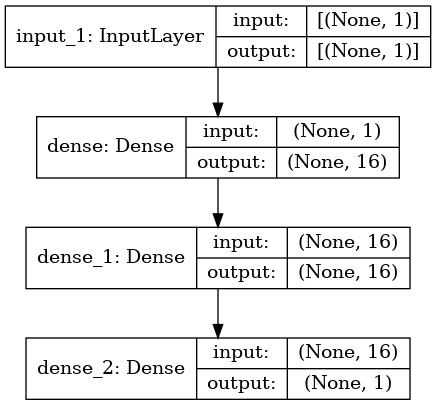

In [67]:
# It's best practice to clear any old model data out every time that you retrain the model. Some parameters from
# previous runs may be left over, and you may end up with a weird/ill-fitting model

modelnames = [
    'NN_lf_uni1',
    'NN_lf_lhs1',
    'NN_lf_uni2',
    'NN_lf_lhs2',
    'NN_lf_uni3',
    'NN_lf_lhs3',
    'NN_hf_uni1',
    'NN_hf_lhs1',
    'NN_hf_uni2',
    'NN_hf_lhs2',
    'NN_hf_uni3',
    'NN_hf_lhs3',
]
for name in modelnames:
    locals()[name] = None
    
#############

###### LOW FIDELITY ########
NN_lf_uni1 = build_model_single_fidelity(xt_LF_uni_bench1, yt_lf1_uni_scaled, ref_size, rate, reg)
NN_lf_lhs1 = build_model_single_fidelity(xt_LF_lhs_bench1, yt_lf1_lhs_scaled, ref_size, rate, reg)

NN_lf_uni2 = build_model_single_fidelity(xt_LF_uni_bench2, yt_lf2_uni_scaled, ref_size, rate, reg)
NN_lf_lhs2 = build_model_single_fidelity(xt_LF_lhs_bench2, yt_lf2_lhs_scaled, ref_size, rate, reg)

NN_lf_uni3 = build_model_single_fidelity(xt_LF_uni_bench3, yt_lf3_uni_scaled, ref_size, rate, reg)
NN_lf_lhs3 = build_model_single_fidelity(xt_LF_lhs_bench3, yt_lf3_lhs_scaled, ref_size, rate, reg)

###### HIGH FIDELITY ########
NN_hf_uni1 = build_model_single_fidelity(xt_HF_uni_bench1, yt_hf1_uni_scaled, ref_size, rate, reg)
NN_hf_lhs1 = build_model_single_fidelity(xt_HF_lhs_bench1, yt_hf1_lhs_scaled, ref_size, rate, reg)

NN_hf_uni2 = build_model_single_fidelity(xt_HF_uni_bench2, yt_hf2_uni_scaled, ref_size, rate, reg)
NN_hf_lhs2 = build_model_single_fidelity(xt_HF_lhs_bench2, yt_hf2_lhs_scaled, ref_size, rate, reg)

NN_hf_uni3 = build_model_single_fidelity(xt_HF_uni_bench3, yt_hf3_uni_scaled, ref_size, rate, reg)
NN_hf_lhs3 = build_model_single_fidelity(xt_HF_lhs_bench3, yt_hf3_lhs_scaled, ref_size, rate, reg)

##Check to see if your model is built correctly, feel free to use any of the above models to test the 
## functionality. This function becomes much more useful when we have more than one input or output, or 
## multi-dimensional input and output
tf.keras.utils.plot_model(NN_lf_uni1,show_shapes=True)

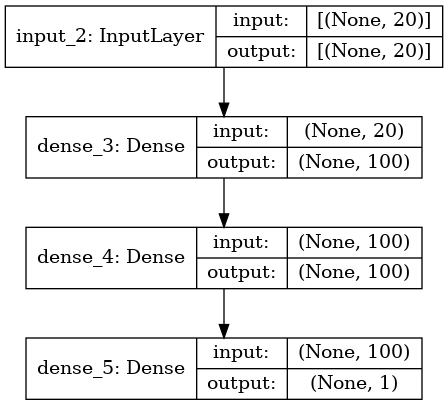

In [10]:
# yt_hf4 = hf_function_bench4(x_hf4)
# yt_lf4 = lf_function_bench4(x_lf4)
# yt_lf4_scaled = lfScaler4.fit_transform(yt_lf4)
# yt_hf4_scaled = hfScaler4.fit_transform(yt_hf4)

NN_hf_4 = build_model_single_fidelity(x_hf4, yt_hf4_scaled, ref_size, rate, reg)
NN_lf_4 = build_model_single_fidelity(x_lf4, yt_lf4_scaled, ref_size, rate, reg)

##Check to see if your model is built correctly, feel free to use any of the above models to test the 
## functionality. This function becomes much more useful when we have more than one input or output, or 
## multi-dimensional input and output
tf.keras.utils.plot_model(NN_lf_4,show_shapes=True)

## Train the Single Fidelity Models

In [69]:
#Train the Model 

# LFepochs, LFhistory = train_model_all_fidelity(LFmodel, input_data, output_data, numEpochs, myBatchSize, validSplit)

#Benchmark function 1, low fidelity
LFEpochs_uni1, LFHistory_uni1 = train_model_all_fidelity(
    NN_lf_uni1,xt_LF_uni_bench1, yt_lf1_uni_scaled,numEpochs, myBatchSize, validSplit)

LFEpochs_lhs1, LFHistory_lhs1 = train_model_all_fidelity(
    NN_lf_lhs1,xt_LF_lhs_bench1, yt_lf1_lhs_scaled,numEpochs, myBatchSize, validSplit)

#Benchmark function 2, low fidelity
LFEpochs_uni2, LFHistory_uni2 = train_model_all_fidelity(
    NN_lf_uni2,xt_LF_uni_bench2, yt_lf2_uni_scaled,numEpochs, myBatchSize, validSplit)

LFEpochs_lhs2, LFHistory_lhs2 = train_model_all_fidelity(
    NN_lf_lhs2,xt_LF_lhs_bench2, yt_lf2_lhs_scaled,numEpochs, myBatchSize, validSplit)

#Benchmark function 3, low fidelity
LFEpochs_uni3, LFHistory_uni3 = train_model_all_fidelity(
    NN_lf_uni3,xt_LF_uni_bench3, yt_lf3_uni_scaled,numEpochs, myBatchSize, validSplit)

LFEpochs_lhs3, LFHistory_lhs3 = train_model_all_fidelity(
    NN_lf_lhs3,xt_LF_lhs_bench3, yt_lf3_lhs_scaled,numEpochs, myBatchSize, validSplit)

##########################################################################################

#Benchmark function 1, high fidelity
HFEpochs_uni1, HFHistory_uni1 = train_model_all_fidelity(
    NN_hf_uni1,xt_HF_uni_bench1, yt_hf1_uni_scaled,numEpochs, myBatchSize, validSplit)

HFEpochs_lhs1, HFHistory_lhs1 = train_model_all_fidelity(
    NN_hf_lhs1,xt_HF_lhs_bench1, yt_hf1_lhs_scaled,numEpochs, myBatchSize, validSplit)

#Benchmark function 2, high fidelity
HFEpochs_uni2, HFHistory_uni2 = train_model_all_fidelity(
    NN_hf_uni2,xt_HF_uni_bench2, yt_hf2_uni_scaled,numEpochs, myBatchSize, validSplit)

HFEpochs_lhs2, HFHistory_lhs2 = train_model_all_fidelity(
    NN_hf_lhs2,xt_HF_lhs_bench2, yt_hf2_lhs_scaled,numEpochs, myBatchSize, validSplit)

#Benchmark function 3, high fidelity
HFEpochs_uni3, HFHistory_uni3 = train_model_all_fidelity(
    NN_hf_uni3,xt_HF_uni_bench3, yt_hf3_uni_scaled,numEpochs, myBatchSize, validSplit)

HFEpochs_lhs3, HFHistory_lhs3 = train_model_all_fidelity(
    NN_hf_lhs3,xt_HF_lhs_bench3, yt_hf3_lhs_scaled,numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 06276: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 05584: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 07921: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 08436: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 08244: early stopping


In [11]:

# yt_hf4 = hf_function_bench4(x_hf4)
# yt_lf4 = lf_function_bench4(x_lf4)
# yt_lf4_scaled = lfScaler4.fit_transform(yt_lf4)
# yt_hf4_scaled = hfScaler4.fit_transform(yt_hf4)
# NN_hf_4 = build_model_single_fidelity(x_hf4, yt_hf4_scaled, ref_size, rate, reg)
# NN_lf_4 = build_model_single_fidelity(x_lf4, yt_lf4_scaled, ref_size, rate, reg)

#Benchmark function 4, high fidelity
HFEpochs_4, HFHistory_4 = train_model_all_fidelity(
    NN_hf_4,x_hf4, yt_hf4_scaled,numEpochs, myBatchSize, validSplit)

LFEpochs4, LFHistory_4 = train_model_all_fidelity(
    NN_lf_4,x_lf4, yt_lf4_scaled,numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## Analyze Error (MSE) In Single Fidelity Models

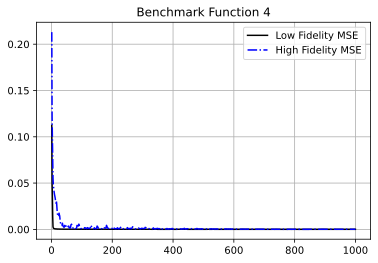

In [14]:
mse_history_hf4 = HFHistory_4["mean_squared_error"]
mse_history_lf4 = LFHistory_4["mean_squared_error"]

plt.plot(range(1,len(mse_history_lf4[:]) + 1),mse_history_lf4[:],
              label="Low Fidelity MSE",linestyle="-", color="k")
plt.plot(range(1,len(mse_history_hf4[:]) + 1),mse_history_hf4[:],
              label="High Fidelity MSE",linestyle="-.", color="b")
plt.title("Benchmark Function 4")
plt.legend(loc=0)
plt.grid()

In [16]:
y_hf_nn4_predicted = NN_hf_4.predict(x_hf4)
y_lf_nn4_predicted = NN_lf_4.predict(x_lf4)

y_lf_nn4_predicted = lfScaler4.inverse_transform(y_lf_nn4_predicted)
y_hf_nn4_predicted = hfScaler4.inverse_transform(y_hf_nn4_predicted)

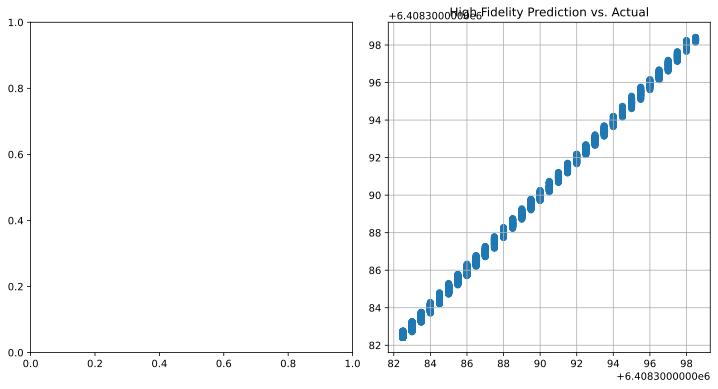

In [18]:
plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# #Benchmark 4, Lofi
# axs[0].scatter(y_lf_nn4_predicted[:],yt_lf4[:]) #.reshape(-1,1)
# #Formatting
# axs[0].set_title("Low Fidelity Prediction vs. Actual")
# axs[0].grid()

#Benchmark 4, Hifi
axs[1].scatter(y_hf_nn4_predicted[:],yt_hf4[:]) #.reshape(-1,1)
#Formatting
axs[1].set_title("High Fidelity Prediction vs. Actual")
axs[1].grid()

In [ ]:
normalized_y_pred_HF = y_hf_nn4_predicted/np.linalg.norm(y_hf_nn4_predicted)
normalized_y_pred_LF = y_lf_nn4_predicted/np.linalg.norm(y_lf_nn4_predicted)

normalized_y_true_HF = yt_hf4/np.linalg.norm(y_hf_nn4_predicted)
normalized_y_true_LF = yt_lf4/np.linalg.norm(y_lf_nn4_predicted)

In [ ]:
normalized_y_pred_HF.reshape(1,-1)
normalized_y_true_HF.reshape(1,-1)
normalized_y_pred_LF.reshape(1,-1)
normalized_y_true_LF.reshape(1,-1)

array([[0.0057735, 0.0057735, 0.0057735, ..., 0.0057735, 0.0057735,
        0.0057735]])

In [ ]:
# plt.rcParams["figure.figsize"] = (10,10)
# fig, axs = plt.subplots(1, 2)
# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# #Benchmark 4, Lofi
# axs[0].scatter(normalized_y_pred_HF[:],normalized_y_true_HF[:]) #.reshape(-1,1)
# #Formatting
# axs[0].set_title("Low Fidelity Prediction vs. Actual")
# axs[0].grid()

# #Benchmark 4, Hifi
# axs[1].scatter(normalized_y_pred_LF[:],normalized_y_true_LF[:]) #.reshape(-1,1)
# #Formatting
# axs[1].set_title("High Fidelity Prediction vs. Actual")
# axs[1].grid()

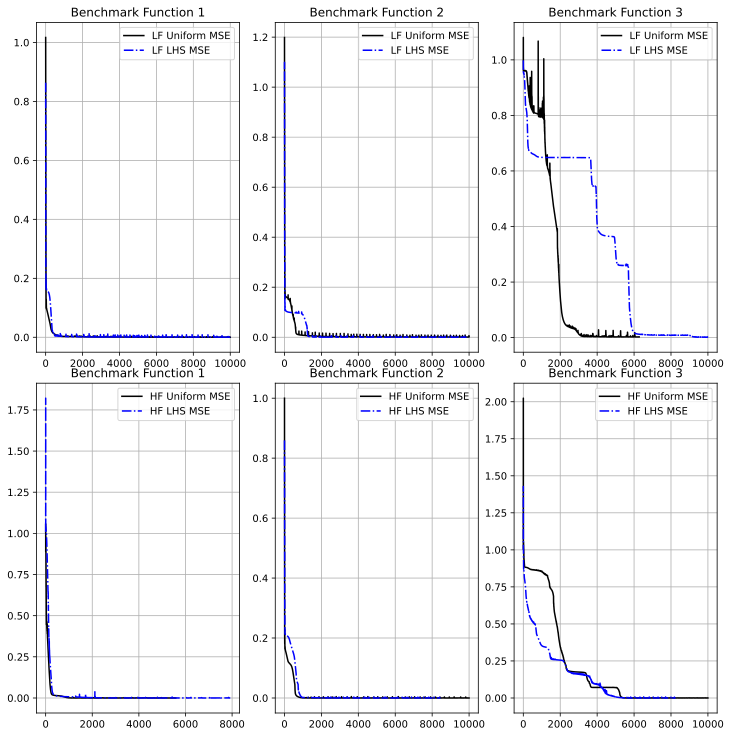

In [70]:
###### Low Fidelity Mean Squared Error
mse_history_lfUni1 = LFHistory_uni1["mean_squared_error"]
mse_history_lfLHS1 = LFHistory_lhs1["mean_squared_error"]
mse_history_lfUni2 = LFHistory_uni2["mean_squared_error"]
mse_history_lfLHS2 = LFHistory_lhs2["mean_squared_error"]
mse_history_lfUni3 = LFHistory_uni3["mean_squared_error"]
mse_history_lfLHS3 = LFHistory_lhs3["mean_squared_error"]

mse_history_hfUni1 = HFHistory_uni1["mean_squared_error"]
mse_history_hfLHS1 = HFHistory_lhs1["mean_squared_error"]
mse_history_hfUni2 = HFHistory_uni2["mean_squared_error"]
mse_history_hfLHS2 = HFHistory_lhs2["mean_squared_error"]
mse_history_hfUni3 = HFHistory_uni3["mean_squared_error"]
mse_history_hfLHS3 = HFHistory_lhs3["mean_squared_error"]


# plt.plot(range(1,len(mse_history[1000:]) + 1),mse_history[1000:])
# plt.xlabel("Epochs")
# plt.ylabel("Mean Squared Error")
# plt.show()

plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 3)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Low Fidelity NN MSE, Benchmark 1
axs[0,0].plot(range(1,len(mse_history_lfUni1[:]) + 1),mse_history_lfUni1[:],
              label="LF Uniform MSE",linestyle="-", color="k")
axs[0,0].plot(range(1,len(mse_history_lfLHS1[:]) + 1),mse_history_lfLHS1[:],
              label="LF LHS MSE",linestyle="-.", color="b")
axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Low Fidelity NN MSE, Benchmark 2
axs[0,1].plot(range(1,len(mse_history_lfUni2[:]) + 1),mse_history_lfUni2[:],
              label="LF Uniform MSE",linestyle="-", color="k")
axs[0,1].plot(range(1,len(mse_history_lfLHS2[:]) + 1),mse_history_lfLHS2[:],
              label="LF LHS MSE",linestyle="-.", color="b")
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Low Fidelity NN MSE, Benchmark 3
axs[0,2].plot(range(1,len(mse_history_lfUni3[:]) + 1),mse_history_lfUni3[:],
              label="LF Uniform MSE",linestyle="-", color="k")
axs[0,2].plot(range(1,len(mse_history_lfLHS3[:]) + 1),mse_history_lfLHS3[:],
              label="LF LHS MSE",linestyle="-.", color="b")
axs[0,2].set_title("Benchmark Function 3")
axs[0,2].legend(loc=0)
axs[0,2].grid()

################################################################

# High Fidelity NN MSE, Benchmark 1
axs[1,0].plot(range(1,len(mse_history_hfUni1[:]) + 1),mse_history_hfUni1[:],
              label="HF Uniform MSE",linestyle="-", color="k")
axs[1,0].plot(range(1,len(mse_history_hfLHS1[:]) + 1),mse_history_hfLHS1[:],
              label="HF LHS MSE",linestyle="-.", color="b")
axs[1,0].set_title("Benchmark Function 1")
axs[1,0].legend(loc=0)
axs[1,0].grid()

# High Fidelity NN MSE, Benchmark 2
axs[1,1].plot(range(1,len(mse_history_hfUni2[:]) + 1),mse_history_hfUni2[:],
              label="HF Uniform MSE",linestyle="-", color="k")
axs[1,1].plot(range(1,len(mse_history_hfLHS2[:]) + 1),mse_history_hfLHS2[:],
              label="HF LHS MSE",linestyle="-.", color="b")
axs[1,1].set_title("Benchmark Function 2")
axs[1,1].legend(loc=0)
axs[1,1].grid()

# High Fidelity NN MSE, Benchmark 3
axs[1,2].plot(range(1,len(mse_history_hfUni3[:]) + 1),mse_history_hfUni3[:],
              label="HF Uniform MSE",linestyle="-", color="k")
axs[1,2].plot(range(1,len(mse_history_hfLHS3[:]) + 1),mse_history_hfLHS3[:],
              label="HF LHS MSE",linestyle="-.", color="b")
axs[1,2].set_title("Benchmark Function 3")
axs[1,2].legend(loc=0)
axs[1,2].grid()

## Generate Predictions

In [71]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

y_lf_nn_uni1 = NN_lf_uni1.predict(x)
y_lf_nn_lhs1 = NN_lf_lhs1.predict(x)
y_lf_nn_uni2 = NN_lf_uni2.predict(x)
y_lf_nn_lhs2 = NN_lf_lhs2.predict(x)
y_lf_nn_uni3 = NN_lf_uni3.predict(x)
y_lf_nn_lhs3 = NN_lf_lhs3.predict(x)

y_hf_nn_uni1 = NN_hf_uni1.predict(x)
y_hf_nn_lhs1 = NN_hf_lhs1.predict(x)
y_hf_nn_uni2 = NN_hf_uni2.predict(x)
y_hf_nn_lhs2 = NN_hf_lhs2.predict(x)
y_hf_nn_uni3 = NN_hf_uni3.predict(x)
y_hf_nn_lhs3 = NN_hf_lhs3.predict(x)

y_lf_nn_uni1 = lfScalerUni1.inverse_transform(y_lf_nn_uni1)
y_lf_nn_lhs1 = lfScalerLHS1.inverse_transform(y_lf_nn_lhs1)
y_lf_nn_uni2 = lfScalerUni2.inverse_transform(y_lf_nn_uni2)
y_lf_nn_lhs2 = lfScalerLHS2.inverse_transform(y_lf_nn_lhs2)
y_lf_nn_uni3 = lfScalerUni3.inverse_transform(y_lf_nn_uni3)
y_lf_nn_lhs3 = lfScalerLHS3.inverse_transform(y_lf_nn_lhs3)

y_hf_nn_uni1 = hfScalerUni1.inverse_transform(y_hf_nn_uni1)
y_hf_nn_lhs1 = hfScalerLHS1.inverse_transform(y_hf_nn_lhs1)
y_hf_nn_uni2 = hfScalerUni2.inverse_transform(y_hf_nn_uni2)
y_hf_nn_lhs2 = hfScalerLHS2.inverse_transform(y_hf_nn_lhs2)
y_hf_nn_uni3 = hfScalerUni3.inverse_transform(y_hf_nn_uni3)
y_hf_nn_lhs3 = hfScalerLHS3.inverse_transform(y_hf_nn_lhs3)

## Plot Generated Predictions

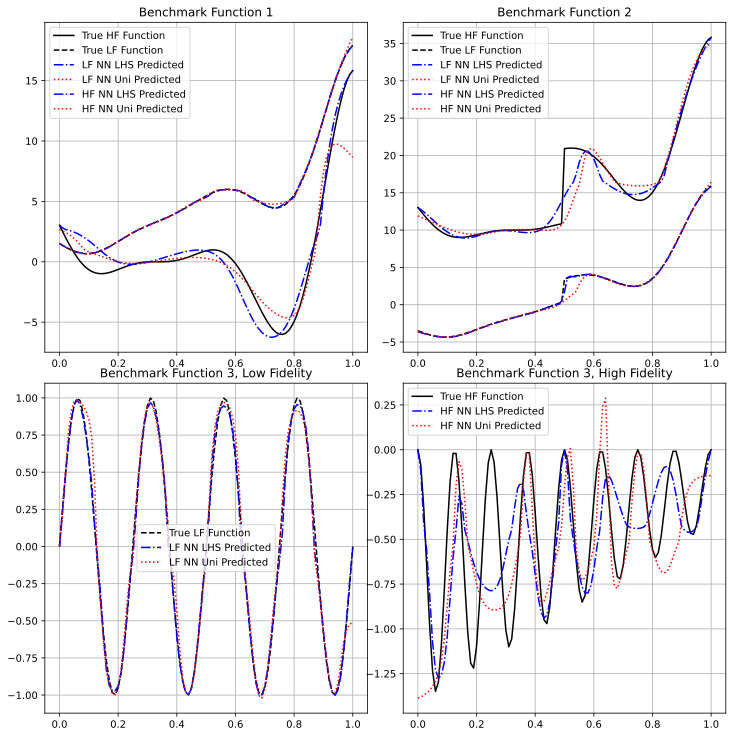

In [72]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Reference Functions, Benchmark 1
axs[0,0].plot(x,hf_function_bench1(x), label="True HF Function",linestyle="-", color="k")
axs[0,0].plot(x,lf_function_bench1(x), label="True LF Function",linestyle="--", color="k")
#Predicted Values 
axs[0,0].plot(x,y_lf_nn_uni1, label="LF NN LHS Predicted",linestyle="-.", color="b")
axs[0,0].plot(x,y_lf_nn_lhs1, label="LF NN Uni Predicted",linestyle=":", color="r")
axs[0,0].plot(x,y_hf_nn_uni1, label="HF NN LHS Predicted",linestyle="-.", color="b")
axs[0,0].plot(x,y_hf_nn_lhs1, label="HF NN Uni Predicted",linestyle=":", color="r")
#Formatting
axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Reference Functions, Benchmark 2
axs[0,1].plot(x,y_truth_hf2_uni, label="True HF Function",linestyle="-", color="k")
axs[0,1].plot(x,y_truth_lf2_uni, label="True LF Function",linestyle="--", color="k")
#Predicted Values 
axs[0,1].plot(x,y_lf_nn_uni2, label="LF NN LHS Predicted",linestyle="-.", color="b")
axs[0,1].plot(x,y_lf_nn_lhs2, label="LF NN Uni Predicted",linestyle=":", color="r")
axs[0,1].plot(x,y_hf_nn_uni2, label="HF NN LHS Predicted",linestyle="-.", color="b")
axs[0,1].plot(x,y_hf_nn_lhs2, label="HF NN Uni Predicted",linestyle=":", color="r")
#Formatting
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Reference Functions, Benchmark 3
axs[1,0].plot(x,lf_function_bench3(x), label="True LF Function",linestyle="--", color="k")
#Predicted Values
axs[1,0].plot(x,y_lf_nn_uni3, label="LF NN LHS Predicted",linestyle="-.", color="b")
axs[1,0].plot(x,y_lf_nn_lhs3, label="LF NN Uni Predicted",linestyle=":", color="r")
#Formatting
axs[1,0].set_title("Benchmark Function 3, Low Fidelity")
axs[1,0].legend(loc=0)
axs[1,0].grid()

#Reference Functions, Benchmark 3
axs[1,1].plot(x,hf_function_bench3(x), label="True HF Function",linestyle="-", color="k")
#Predicted Values
axs[1,1].plot(x,y_hf_nn_uni3, label="HF NN LHS Predicted",linestyle="-.", color="b")
axs[1,1].plot(x,y_hf_nn_lhs3, label="HF NN Uni Predicted",linestyle=":", color="r")
#Formatting
axs[1,1].set_title("Benchmark Function 3, High Fidelity")
axs[1,1].legend(loc=0)
axs[1,1].grid()


## Multi-Fidelity Neural Networks

In [73]:
## Now, to make our Multi-Fidelity Neural Network 
# input_data = xt_HF_uni_bench1_mod
# output_data = yt_hf1_uni_mod

# yt_LF_in = LFmodel.predict(xt_HF_uni_bench1_mod)
# These y values are already scaled 
yt_lf_uni1_in = NN_lf_uni1.predict(xt_HF_uni_bench1)
yt_lf_lhs1_in = NN_lf_lhs1.predict(xt_HF_lhs_bench1)
yt_lf_uni2_in = NN_lf_uni2.predict(xt_HF_uni_bench2)
yt_lf_lhs2_in = NN_lf_lhs2.predict(xt_HF_lhs_bench2)
yt_lf_uni3_in = NN_lf_uni3.predict(xt_HF_uni_bench3)
yt_lf_lhs3_in = NN_lf_lhs3.predict(xt_HF_lhs_bench3)

# mf_input_data = np.concatenate((xt_HF_uni_bench1_mod,yt_LF_in), axis=1)
mf_uni1_input_data = np.concatenate((xt_HF_uni_bench1,yt_lf_uni1_in), axis = 1)
mf_lhs1_input_data = np.concatenate((xt_HF_lhs_bench1,yt_lf_lhs1_in), axis = 1)
mf_uni2_input_data = np.concatenate((xt_HF_uni_bench2,yt_lf_uni2_in), axis = 1)
mf_lhs2_input_data = np.concatenate((xt_HF_lhs_bench2,yt_lf_lhs2_in), axis = 1)
mf_uni3_input_data = np.concatenate((xt_HF_uni_bench3,yt_lf_uni3_in), axis = 1)
mf_lhs3_input_data = np.concatenate((xt_HF_lhs_bench3,yt_lf_lhs3_in), axis = 1)

# Scale your predicted low fidelity data 
# This loop erases any previous object associated to the variable name, then 
# points the variable name to a preprocessing object 
# modelnames = [
#     'mfScaleruni1',
#     'mfScalerlhs1',
#     'mfScaleruni2',
#     'mfScalerlhs2',
#     'mfScaleruni3',
#     'mfScalerlhs3',
# ]
# for name in modelnames:
#     locals()[name] = None
#     locals()[name] = preprocessing.StandardScaler()


# yt_lf_uni1_in = mfScaleruni1.fit_transform(yt_lf_uni1_in)
# yt_lf_lhs1_in = mfScalerlhs1.fit_transform(yt_lf_lhs1_in)
# yt_lf_uni2_in = mfScaleruni2.fit_transform(yt_lf_uni2_in)
# yt_lf_lhs2_in = mfScalerlhs2.fit_transform(yt_lf_lhs2_in)
# yt_lf_uni3_in = mfScaleruni3.fit_transform(yt_lf_uni3_in)
# yt_lf_lhs3_in = mfScalerlhs3.fit_transform(yt_lf_lhs3_in)

# Multi-Fidelity Output Data = hf_BenchmarkFunction(High Fidelity Training Inputs, "x")
mf_uni1_output_data = yt_hf1_uni_scaled
mf_lhs1_output_data = yt_hf1_lhs_scaled
mf_uni2_output_data = yt_hf2_uni_scaled
mf_lhs2_output_data = yt_hf2_lhs_scaled
mf_uni3_output_data = yt_hf3_uni_scaled
mf_lhs3_output_data = yt_hf3_lhs_scaled

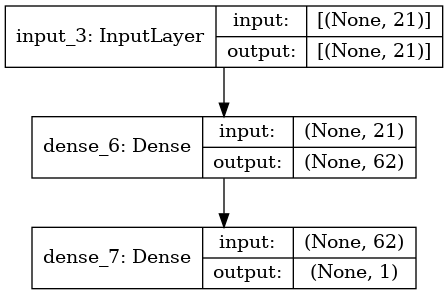

In [20]:
## Now, to make our Multi-Fidelity Neural Network 
# input_data = xt_HF_uni_bench1_mod
# output_data = yt_hf1_uni_mod

# yt_hf4 = hf_function_bench4(x_hf4)
# yt_lf4 = lf_function_bench4(x_lf4)
# yt_lf4_scaled = lfScaler4.fit_transform(yt_lf4)
# yt_hf4_scaled = hfScaler4.fit_transform(yt_hf4)
# NN_hf_4 = build_model_single_fidelity(x_hf4, yt_hf4_scaled, ref_size, rate, reg)
# NN_lf_4 = build_model_single_fidelity(x_lf4, yt_lf4_scaled, ref_size, rate, reg)

# yt_LF_in = LFmodel.predict(xt_HF_uni_bench1_mod)
# These y values are already scaled 
yt_lf_4_in = NN_lf_4.predict(x_hf4)

# mf_input_data = np.concatenate((xt_HF_uni_bench1_mod,yt_LF_in), axis=1)
mf_4_input_data = np.concatenate((x_hf4,yt_lf_4_in), axis = 1)

# Multi-Fidelity Output Data = hf_BenchmarkFunction(High Fidelity Training Inputs, "x")
mf_4_output_data = yt_hf4_scaled

ref_size_mf4 = 62
NN_mf_4 = build_model_multi_fidelity(mf_4_input_data, mf_4_output_data, ref_size_mf4, rate, reg)

tf.keras.utils.plot_model(NN_mf_4,show_shapes=True)

In [22]:
NN_mf_uni1_epochs, NN_mf_uni1_history = train_model_all_fidelity(NN_mf_4, mf_4_input_data, mf_4_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

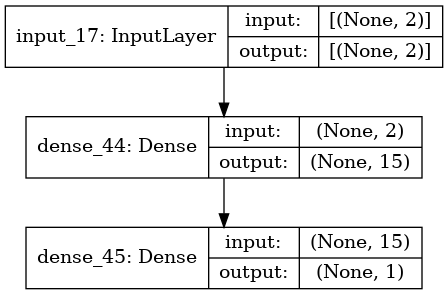

In [74]:
#Initialize hyperparamters for Multi Fidelity Model
# ref_size = 34 #this is whats used in the paper 
ref_size_uni1 = int(len(mf_uni1_input_data))
ref_size_lhs1 = int(len(mf_lhs1_input_data))
ref_size_uni2 = int(len(mf_uni2_input_data))
ref_size_lhs2 = int(len(mf_lhs2_input_data))
ref_size_uni3 = int(len(mf_uni3_input_data))
ref_size_lhs3 = int(len(mf_lhs3_input_data))
# The below hyperparameters remain unchanged
# rate = 5.17e-2 #Learning rate
# reg = 1.01e-4
# numEpochs = 10000
# myBatchSize = None
# validSplit = None

#Clearing old models, if there are any 
modelnames = [
    'NN_mf_uni1',
    'NN_mf_lhs1',
    'NN_mf_uni2',
    'NN_mf_lhs2',
    'NN_mf_uni3',
    'NN_mf_lhs3',
]
for name in modelnames:
    locals()[name] = None

##Build the model, show the graph
# MFmodel = build_model_multi_fidelity(mf_input_data, mf_output_data, ref_size, rate, reg)
NN_mf_uni1 = build_model_multi_fidelity(mf_uni1_input_data, mf_uni1_output_data, ref_size_uni1, rate, reg)
NN_mf_lhs1 = build_model_multi_fidelity(mf_lhs1_input_data, mf_lhs1_output_data, ref_size_lhs1, rate, reg)
NN_mf_uni2 = build_model_multi_fidelity(mf_uni2_input_data, mf_uni2_output_data, ref_size_uni2, rate, reg)
NN_mf_lhs2 = build_model_multi_fidelity(mf_lhs2_input_data, mf_lhs2_output_data, ref_size_lhs2, rate, reg)
NN_mf_uni3 = build_model_multi_fidelity(mf_uni3_input_data, mf_uni3_output_data, ref_size_uni3, rate, reg)
NN_mf_lhs3 = build_model_multi_fidelity(mf_lhs3_input_data, mf_lhs3_output_data, ref_size_lhs3, rate, reg)

tf.keras.utils.plot_model(NN_mf_uni3,show_shapes=True)

In [92]:
#Train the model 

modelnames = [
    'NN_mf_uni1_epochs',
    'NN_mf_uni1_history',
    'NN_mf_lhs1_epochs',
    'NN_mf_lhs1_history',
    'NN_mf_uni2_epochs',
    'NN_mf_uni2_history',
    'NN_mf_lhs2_epochs',
    'NN_mf_lhs2_history',
    'NN_mf_uni3_epcohs',
    'NN_mf_uni3_history',
    'NN_mf_lhs3_epochs',
    'NN_mf_lhs3_history',
]
for name in modelnames:
    locals()[name] = None
numEpochs = 10000
    
# MFepochs, MFhistory = train_model_all_fidelity(MFmodel, mf_input_data, mf_output_data, numEpochs, myBatchSize, validSplit)
NN_mf_uni1_epochs, NN_mf_uni1_history = train_model_all_fidelity(NN_mf_uni1, mf_uni1_input_data, mf_uni1_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)
NN_mf_lhs1_epochs, NN_mf_lhs1_history = train_model_all_fidelity(NN_mf_lhs1, mf_lhs1_input_data, mf_lhs1_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)
NN_mf_uni2_epochs, NN_mf_uni2_history = train_model_all_fidelity(NN_mf_uni2, mf_uni2_input_data, mf_uni2_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)
NN_mf_lhs2_epochs, NN_mf_lhs2_history = train_model_all_fidelity(NN_mf_lhs2, mf_lhs2_input_data, mf_lhs2_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)
NN_mf_uni3_epcohs, NN_mf_uni3_history = train_model_all_fidelity(NN_mf_uni3, mf_uni3_input_data, mf_uni3_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)
NN_mf_lhs3_epochs, NN_mf_lhs3_history = train_model_all_fidelity(NN_mf_lhs3, mf_lhs3_input_data, mf_lhs3_output_data, 
                                                                 numEpochs, myBatchSize, validSplit)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 09897: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 01596: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 02994: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 06174: early stopping


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [93]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# mf_predict_input = np.concatenate((x,y_lf_nn),axis=1)
# y_lf_nn_uni1
y_lf_nn_uni1 = NN_lf_uni1.predict(x)
y_lf_nn_lhs1 = NN_lf_lhs1.predict(x)
y_lf_nn_uni2 = NN_lf_uni2.predict(x)
y_lf_nn_lhs2 = NN_lf_lhs2.predict(x)
y_lf_nn_uni3 = NN_lf_uni3.predict(x)
y_lf_nn_lhs3 = NN_lf_lhs3.predict(x)

mf_predict_input_uni1 = np.concatenate((x,y_lf_nn_uni1),axis=1)
mf_predict_input_lhs1 = np.concatenate((x,y_lf_nn_lhs1),axis=1)
mf_predict_input_uni2 = np.concatenate((x,y_lf_nn_uni2),axis=1)
mf_predict_input_lhs2 = np.concatenate((x,y_lf_nn_lhs2),axis=1)
mf_predict_input_uni3 = np.concatenate((x,y_lf_nn_uni3),axis=1)
mf_predict_input_lhs3 = np.concatenate((x,y_lf_nn_lhs3),axis=1)

# y_mf_nn = MFmodel.predict(mf_predict_input)
y_mf_nn_uni1_predicted = NN_mf_uni1.predict(mf_predict_input_uni1)
y_mf_nn_lhs1_predicted = NN_mf_lhs1.predict(mf_predict_input_lhs1)
y_mf_nn_uni2_predicted = NN_mf_uni2.predict(mf_predict_input_uni2)
y_mf_nn_lhs2_predicted = NN_mf_lhs2.predict(mf_predict_input_lhs2)
y_mf_nn_uni3_predicted = NN_mf_uni3.predict(mf_predict_input_uni3)
y_mf_nn_lhs3_predicted = NN_mf_lhs3.predict(mf_predict_input_lhs3)

y_mf_nn_uni1_predicted = hfScalerUni1.inverse_transform(y_mf_nn_uni1_predicted)
y_mf_nn_lhs1_predicted = hfScalerLHS1.inverse_transform(y_mf_nn_lhs1_predicted)
y_mf_nn_uni2_predicted = hfScalerUni2.inverse_transform(y_mf_nn_uni2_predicted)
y_mf_nn_lhs2_predicted = hfScalerLHS2.inverse_transform(y_mf_nn_lhs2_predicted)
y_mf_nn_uni3_predicted = hfScalerUni3.inverse_transform(y_mf_nn_uni3_predicted)
y_mf_nn_lhs3_predicted = hfScalerLHS3.inverse_transform(y_mf_nn_lhs3_predicted)

In [38]:
# yt_hf4 = hf_function_bench4(x_hf4)
# yt_lf4 = lf_function_bench4(x_lf4)
# yt_lf4_scaled = lfScaler4.fit_transform(yt_lf4)
# yt_hf4_scaled = hfScaler4.fit_transform(yt_hf4)
x_comp = np.random.uniform(low=-3,high=3,size=(5000,20))

In [39]:
y_lf_nn_mf4 = NN_lf_4.predict(x_comp)

In [40]:
mf_predict_input_mf4 = np.concatenate((x_comp,y_lf_nn_mf4),axis=1)

In [41]:
mf_predict_input_mf4.shape

(5000, 21)

In [42]:
y_mf_nn_4_predicted = NN_mf_4.predict(mf_predict_input_mf4)

In [43]:
y_mf_nn_4_predicted = hfScaler4.inverse_transform(y_mf_nn_4_predicted)

In [44]:
y_mf_4_actual = hf_function_bench4(x_comp)

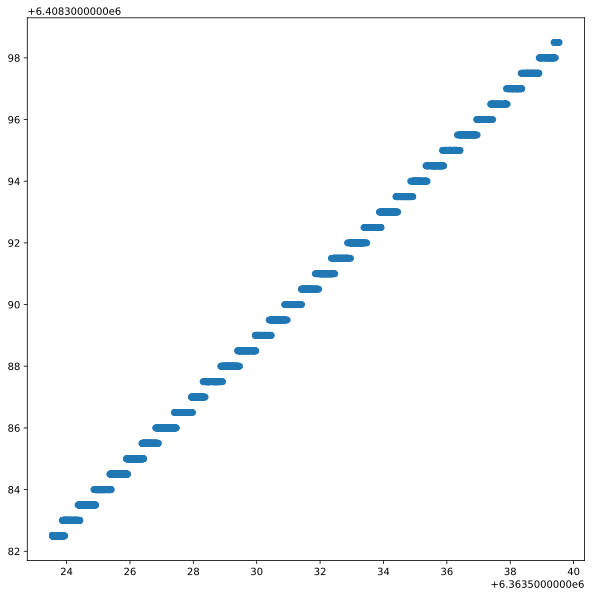

In [46]:
plt.scatter(y_mf_4_actual[:], y_mf_nn_4_predicted[:])

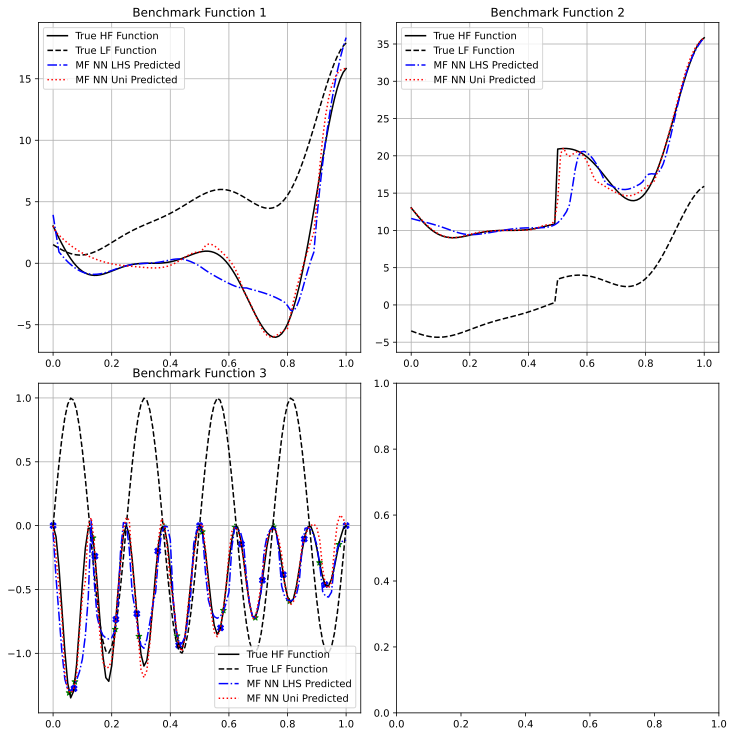

In [94]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Reference Functions, Benchmark 1
axs[0,0].plot(x,hf_function_bench1(x), label="True HF Function",linestyle="-", color="k")
axs[0,0].plot(x,lf_function_bench1(x), label="True LF Function",linestyle="--", color="k")
#Predicted Values 
axs[0,0].plot(x,y_mf_nn_lhs1_predicted, label="MF NN LHS Predicted",linestyle="-.", color="b")
axs[0,0].plot(x,y_mf_nn_uni1_predicted, label="MF NN Uni Predicted",linestyle=":", color="r")
axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Reference Functions, Benchmark 2
axs[0,1].plot(x,y_truth_hf2_uni, label="True HF Function",linestyle="-", color="k")
axs[0,1].plot(x,y_truth_lf2_uni, label="True LF Function",linestyle="--", color="k")
#Training Points
axs[0,1].plot(x,y_mf_nn_lhs2_predicted, label="MF NN LHS Predicted",linestyle="-.", color="b")
axs[0,1].plot(x,y_mf_nn_uni2_predicted, label="MF NN Uni Predicted",linestyle=":", color="r")
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Reference Functions, Benchmark 3
axs[1,0].plot(x,hf_function_bench3(x), label="True HF Function",linestyle="-", color="k")
axs[1,0].plot(x,lf_function_bench3(x), label="True LF Function",linestyle="--", color="k")

axs[1,0].plot(x,y_mf_nn_lhs3_predicted, label="MF NN LHS Predicted",linestyle="-.", color="b")
axs[1,0].plot(x,y_mf_nn_uni3_predicted, label="MF NN Uni Predicted",linestyle=":", color="r")
axs[1,0].set_title("Benchmark Function 3")
axs[1,0].legend(loc=0)
axs[1,0].grid()

#Training Points
axs[1,0].scatter(xt_HF_lhs_bench3, yt_hf3_lhs, marker="*", color="g", label = "HF LHS Points")
# axs[1,0].scatter(xt_LF_lhs_bench3, yt_lf3_lhs, marker="o", color="g", label = "LF LHS Points")
axs[1,0].scatter(xt_HF_uni_bench3, yt_hf3_uni, marker="X", color="b", label = "HF Uniform Points")
# axs[1,0].scatter(xt_LF_uni_bench3, yt_lf3_uni, marker="d", color="b", label = "LF Uniform Points")

## Analyze MSE in MF Neural Networks

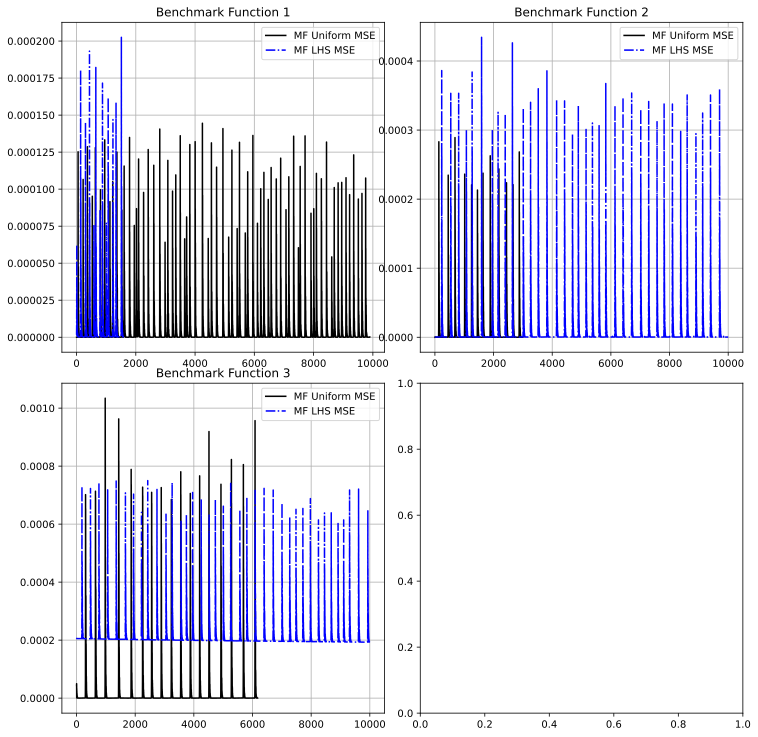

In [95]:
NN_mf_uni1_epochs, NN_mf_uni1_history 

###### Low Fidelity Mean Squared Error
mse_history_mfUni1 = NN_mf_uni1_history["mean_squared_error"]
mse_history_mfLHS1 = NN_mf_lhs1_history["mean_squared_error"]
mse_history_mfUni2 = NN_mf_uni2_history["mean_squared_error"]
mse_history_mfLHS2 = NN_mf_lhs2_history["mean_squared_error"]
mse_history_mfUni3 = NN_mf_uni3_history["mean_squared_error"]
mse_history_mfLHS3 = NN_mf_lhs3_history["mean_squared_error"]

# plt.plot(range(1,len(mse_history[1000:]) + 1),mse_history[1000:])
# plt.xlabel("Epochs")
# plt.ylabel("Mean Squared Error")
# plt.show()

plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#Low Fidelity NN MSE, Benchmark 1
axs[0,0].plot(range(1,len(mse_history_mfUni1[:]) + 1),mse_history_mfUni1[:],
              label="MF Uniform MSE",linestyle="-", color="k")
axs[0,0].plot(range(1,len(mse_history_mfLHS1[:]) + 1),mse_history_mfLHS1[:],
              label="MF LHS MSE",linestyle="-.", color="b")
axs[0,0].set_title("Benchmark Function 1")
axs[0,0].legend(loc=0)
axs[0,0].grid()

#Low Fidelity NN MSE, Benchmark 2
axs[0,1].plot(range(1,len(mse_history_mfUni2[:]) + 1),mse_history_mfUni2[:],
              label="MF Uniform MSE",linestyle="-", color="k")
axs[0,1].plot(range(1,len(mse_history_mfLHS2[:]) + 1),mse_history_mfLHS2[:],
              label="MF LHS MSE",linestyle="-.", color="b")
axs[0,1].set_title("Benchmark Function 2")
axs[0,1].legend(loc=0)
axs[0,1].grid()

#Low Fidelity NN MSE, Benchmark 3
axs[1,0].plot(range(1,len(mse_history_mfUni3[:]) + 1),mse_history_mfUni3[:],
              label="MF Uniform MSE",linestyle="-", color="k")
axs[1,0].plot(range(1,len(mse_history_mfLHS3[:]) + 1),mse_history_mfLHS3[:],
              label="MF LHS MSE",linestyle="-.", color="b")
axs[1,0].set_title("Benchmark Function 3")
axs[1,0].legend(loc=0)
axs[1,0].grid()

# Dictionary Practice

# Misc

#### np.linspace 
Creating n number of points between x0 and x1. In our instance, x0 = 0, x1 = 1, n = 101
The reshape here turns the row vector into a column vector. From the documentation: numpy advice/error message, to use reshape(-1,1) for a single feature; i.e. single column. Reshape your data using array.reshape(-1, 1) if your data has a single feature. 

Passing a -1 to reshape tells numpy that you want it to figure out what that dimension should be based on the data you passed it, and we've told it we want to have 1 column. 

#### predict_derivatives
For this example, we're asking our model to produce the derivatives at each point x (created by np.linspace), and the kx=0 says to look at the first column of our np.array x. From the documentation: 

    Predict the dy_dx derivatives at a set of points.
    
    Parameters
    ----------
    x : np.ndarray[nt, nx] or np.ndarray[nt]
        Input values for the prediction points.
    kx : int
        The 0-based index of the input variable with respect to which derivatives are desired.
    
    Returns
    -------
    dy_dx : np.ndarray[nt, ny]
        Derivatives.